# StatCan Data on International and Domestic postsecondary institution (PSI) student enrolment, Academic Years (AY) 2009/10 - 2022/23, Full-time (FT) students only

### Note on Enrolment vs Study permits issued (for international student analysis):
- Study permits issued are a prerequisite to enrolment, but will not 100% translate into enrolment - some will not enrol for personal or other immigration related issues. More a leading indicator of demand. 
    - It is useful to look at permits issued though and [CBC's analysis pulled from IRCC Data](https://www.cbc.ca/news/canada/toronto/international-student-study-permits-data-1.7125827#Full%20data) used study permits issued as they focus specifically on the international student cap and the conduct of institutions that led to the federal decision. This will be explored later, but the project's initial aim was to look more holistically at the sector, hence data from domestic students is also included and analysis is framed in terms of how much of an institution's student populace has become international students, for what is likely financial and demographic factors (a flatline in domestic enrolment in almost every province.)

    - Another issue of study permits being the leading indicator is the [no-show rate of students](https://www.theglobeandmail.com/politics/article-international-students-school-attendance-data/). It was [only in November 2024](https://www.canada.ca/en/immigration-refugees-citizenship/news/2024/11/new-international-student-program-regulations-take-effect.html) that any mandatory reporting of international student attendance, and study permit compliance began.

- Enrolment is a realised, on the ground student paying tuition, therefore is a more concrete indicator of the institution's reality.

- On 22 February I found [Retrenchment Watch](https://higheredstrategy.com/retrenchment-watch-newsletter/) by Higher Ed Strategy Associates, studying the response of the PSIs to this situation, who are also analysing data from the study permits issued month by month

- Note from Dec 2025: There are many tables from StatCan providing similar postsecondary data around student status/demographic, but [this specific link](https://www150.statcan.gc.ca/t1/tbl1/en/cv.action?pid=3710027701) was used previously in late 2024.

## Imports and preprocessing pipeline

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

# for the preprocessing pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

In [73]:
# Reading in the CSV
df = pd.read_csv("/Users/thomasdoherty/Desktop/canadian-psi-project/psi_data/statcan_data/statcan-FT-canadian-09-23.csv", encoding='utf-8')

Below is the new dataset to be preprocessed for both international and domestic students in one operation:

In [86]:
# Test new data
df_new = pd.read_csv("/Users/thomasdoherty/Desktop/canadian-psi-project/psi_data/statcan_data/statcan-FT-enrol-09-24.csv", encoding='utf-8')

In [87]:
df.sample(5)

,REF_DATE,GEO,DGUID,Field of study,Program type,Credential type,Institution type,Registration status,Status of student in Canada,Gender,...,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
1259,2014/2015,"Collège Heritage / Heritage College, Quebec",NaN,"Total, field of study","Total, program type","Total, credential type","Total, institution type",Full-time student,Canadian students,"Total, gender",...,223,units,0,v1611151995,92.1.1.1.1.2.2.1,1206,NaN,NaN,NaN,0
1995,2017/2018,Collège Boréal d'art appliqués et de technolog...,NaN,"Total, field of study","Total, program type","Total, credential type","Total, institution type",Full-time student,Canadian students,"Total, gender",...,223,units,0,v1612715014,147.1.1.1.1.2.2.1,1146,NaN,NaN,NaN,0
2235,2019/2020,St. Clair College of Applied Arts and Technolo...,NaN,"Total, field of study","Total, program type","Total, credential type","Total, institution type",Full-time student,Canadian students,"Total, gender",...,223,units,0,v1613464119,164.1.1.1.1.2.2.1,9120,NaN,NaN,NaN,0
3071,2012/2013,"University of Northern British Columbia, Briti...",NaN,"Total, field of study","Total, program type","Total, credential type","Total, institution type",Full-time student,Canadian students,"Total, gender",...,223,units,0,v1615645877,228.1.1.1.1.2.2.1,2178,NaN,NaN,NaN,0
2093,2017/2018,"Durham College of Applied Arts and Technology,...",NaN,"Total, field of study","Total, program type","Total, credential type","Total, institution type",Full-time student,Canadian students,"Total, gender",...,223,units,0,v1613004685,154.1.1.1.1.2.2.1,8961,NaN,NaN,NaN,0


In [88]:
df.shape

(3488, 21)

df_new **is the updated dataset containing 2023-24 data, added in December 2025 to this workbook**. This datasheet contains both domestic and international students, so it will need to be split.

In [89]:
df_new.sample(5)

,REF_DATE,GEO,DGUID,Field of study,Program type,Credential type,Institution type,Registration status,Status of student in Canada,Gender,...,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
8810,2023/2024,"St. Mary's University, Alberta",NaN,"Total, field of study","Total, program type","Total, credential type","Total, institution type",Full-time student,Canadian students,"Total, gender",...,223,units,0,v1614960851,207.1.1.1.1.2.2.1,894,NaN,NaN,NaN,0
9038,2011/2012,"Bow Valley College, Alberta",NaN,"Total, field of study","Total, program type","Total, credential type","Total, institution type",Full-time student,International students,"Total, gender",...,223,units,0,v1615032987,213.1.1.1.1.2.3.1,273,NaN,NaN,NaN,0
10917,2010/2011,Nunavut,2021A000162,"Total, field of study","Total, program type","Total, credential type","Total, institution type",Full-time student,Canadian students,"Total, gender",...,223,units,0,v1616530953,257.1.1.1.1.2.2.1,405,NaN,NaN,NaN,0
7683,2016/2017,"University of Manitoba, Manitoba",NaN,"Total, field of study","Total, program type","Total, credential type","Total, institution type",Full-time student,Canadian students,"Total, gender",...,223,units,0,v1613990431,179.1.1.1.1.2.2.1,20625,NaN,NaN,NaN,0
7075,2012/2013,Northern College of Applied Arts and Technolog...,NaN,"Total, field of study","Total, program type","Total, credential type","Total, institution type",Full-time student,Canadian students,"Total, gender",...,223,units,0,v1613435127,163.1.1.1.1.2.2.1,1314,NaN,NaN,NaN,0


In [90]:
df_new.shape

(10963, 21)

Confirm this data is **full-time Canadian students only**

In [91]:
# check type of entry in the Student Status column - only Canadian students
print(df['Status of student in Canada'].value_counts())
print("\n")
# check type of entry & values for registration status - only FT no part time records here
print(df['Registration status'].value_counts())

Status of student in Canada
Canadian students    3488
Name: count, dtype: int64


Registration status
Full-time student    3488
Name: count, dtype: int64


The new datasheet contains both Canadian, international students and the total sums for all institutions. We will do the pipeline transformation once here with domestic, international and combined records all present before filtering for specifics in the sections after (only need to transform once then).

In [95]:
# check type of entry in the Student Status column
print(df_new['Status of student in Canada'].value_counts())
print("\n")
# check type of entry & values for registration status - only FT no part time records here
print(df_new['Registration status'].value_counts())

Status of student in Canada
Total, status of student in Canada    3738
Canadian students                     3736
International students                3489
Name: count, dtype: int64


Registration status
Full-time student    10963
Name: count, dtype: int64


**Note:** We can see there are around 250 records without specific international student records - this may be 2009 or an early year where it was not specifically recorded, or if it is blank due to a zero or admin error... to be investigated.

Check the column names - it seems to have lots of columns which aren't providing info we need

In [96]:
print(df.columns)

Index(['REF_DATE', 'GEO', 'DGUID', 'Field of study', 'Program type',
       'Credential type', 'Institution type', 'Registration status',
       'Status of student in Canada', 'Gender', 'UOM', 'UOM_ID',
       'SCALAR_FACTOR', 'SCALAR_ID', 'VECTOR', 'COORDINATE', 'VALUE', 'STATUS',
       'SYMBOL', 'TERMINATED', 'DECIMALS'],
      dtype='object')


In [97]:
print(df_new.columns)

Index(['REF_DATE', 'GEO', 'DGUID', 'Field of study', 'Program type',
       'Credential type', 'Institution type', 'Registration status',
       'Status of student in Canada', 'Gender', 'UOM', 'UOM_ID',
       'SCALAR_FACTOR', 'SCALAR_ID', 'VECTOR', 'COORDINATE', 'VALUE', 'STATUS',
       'SYMBOL', 'TERMINATED', 'DECIMALS'],
      dtype='object')


Lots of unnecessary columns we can remove eg Registration Status as it is exclusively FT students. This notebook is examining the international / domestic splits in particular, many columns simply 'total x' where x is another demographic explored elsewhere.

Data preprocessing pipeline below.

## Data Preprocessing Pipeline

**Dropping unnecessary columns, reformat the Year column, rename columns of interest**. Using custom transformers to preprocess the data, not ColumnTransformer (from sklearn).

**December 2025 update:** With the updated dataset, I'm adjusting processing steps to make clear boh the international and Canadian student records in this data and so it can still be seen and parsed out easily.

**Why Custom transformers?**
- These operations like renaming columns, dropping columns are global transformations on the dataframe, not specific columns, so ColumnTransformer is not appropriate here
- The operations fundamentally change the structure of the dataframe - less columns are in the output, input data is not preserved. Again not appropriate for ColumnTransformer
- ColumnTransformer expects any operations on different columns to then end in recombining columns (preserving the dataframe structure).

Custom Transformers are defined in the utils folder but called here to transform the raw data. As the initial data exploration of the whole project is here, some transformation steps were not pipelined at this stage, but are in the other workbooks. These include:
- Removing the territories. **Reason:** I wanted to show the relatively tiny contribution to enrolment they made to justify removing them from analysis.
- Pivoting rows so that Domestic/International/Unreported Canadian Status were columns in one single row, rather than two/three separate rows. **Reason:** I initially took domestic and international student data as separate sheets, looking at the larger volume but very static domestic population before moving to the much more analytically significant international student population.

In [98]:
from utils.constants import PROVINCES_TERRITORIES_CA, TERRITORIES, PROVINCE_CODES, ABBREVIATIONS
from utils.pipeline_transformers import DropColumns, RenameColumns, FormatDate, AddInstitutionAndProvince, AbbreviateInstitutionNames, ReorderColumns

In [99]:
# Define this specific pipeline

preprocess_pipeline = Pipeline(steps=[
    # 1. drop columns
    ('drop_columns', DropColumns(columns=[
        'DGUID', 'Registration status', 'Institution type', 'Credential type', 'Program type', 'Field of study', 'Gender', 'UOM', 'UOM_ID',
        'SCALAR_FACTOR', 'SCALAR_ID', 'VECTOR', 'COORDINATE', 'STATUS', 'SYMBOL', 'TERMINATED', 'DECIMALS'
    ])),
    
    # 2. rename columns
    ('rename_columns', RenameColumns(column_names={
        "GEO": "Province/Territory",
        "REF_DATE": "FY Start",
        "VALUE": "Enrolment",
        "Status of student in Canada": "Canadian Status"
    })),

    # 3. formatting FY Start steps
    ('format_fy', FormatDate(column="FY Start")),

    # 4. Add Institution Name and Province columns
    ('add_institution_and_province', AddInstitutionAndProvince(
        column='Province/Territory',
        institution_col='Institution Name', 
        province_col='Province/Territory', 
        provinces=PROVINCES_TERRITORIES_CA
    )),

    # 5. Abbreviate institution names
    ('abbreviate_institution_names', AbbreviateInstitutionNames(
        column='Institution Name', 
        replacements=ABBREVIATIONS
    )),
    
    # 6. Reorder the columns
    ('reorder_columns', ReorderColumns(
        desired_order=['FY Start', 'Province/Territory', 'Institution Name', 'Canadian Status', 'Enrolment']
    ))
])

### Apply the pipeline

In [100]:
processed_df = preprocess_pipeline.fit_transform(df_new)

In [105]:
processed_df.sample(6)

,FY Start,Province/Territory,Institution Name,Canadian Status,Enrolment
7303,2015,Ontario,Sheridan College,Canadian students,13326
2105,2014,Quebec,Cégep d'Ahuntsic,Canadian students,7827
797,2010,Nova Scotia,Saint Mary's U,"Total, status of student in Canada",5793
4850,2018,Quebec,Collège international Marie de France,Canadian students,213
9781,2022,British Columbia,Simon Fraser U,"Total, status of student in Canada",15507
8339,2018,Saskatchewan,Southeast College,Canadian students,1830


In [106]:
processed_df['Institution Name'].value_counts()

Institution Name
Canada (total)             45
Lambton College            45
Cambrian College           45
Centennial College         45
Conestoga College          45
                           ..
U de l'Ontario français     9
U de Hearst                 9
Collège d'Alfred            8
North West College          4
Collège Décarie             3
Name: count, Length: 261, dtype: int64

In [107]:
# check for nulls in institution name and province columns - any mistakes in the pipeline will show up here
print(f"Nulls in 'Institution Name': {processed_df['Institution Name'].isnull().sum()}")
print(f"Nulls in 'Province': {processed_df['Province/Territory'].isnull().sum()}")

Nulls in 'Institution Name': 0
Nulls in 'Province': 0


In [108]:
processed_df.sample(5)

,FY Start,Province/Territory,Institution Name,Canadian Status,Enrolment
9560,2010,Alberta,Portage College,Canadian students,795
7256,2013,Ontario,Seneca College,Canadian students,17427
5827,2012,Ontario,Toronto Metropolitan U,"Total, status of student in Canada",22725
7003,2015,Ontario,Lambton College,International students,1161
10242,2020,British Columbia,North Island College,Canadian students,825


In [109]:
# All provinces and territories are still included
processed_df['Province/Territory'].unique()

array(['Canada', 'Newfoundland and Labrador', 'Prince Edward Island',
       'Nova Scotia', 'New Brunswick', 'Quebec', 'Ontario', 'Manitoba',
       'Saskatchewan', 'Alberta', 'British Columbia', 'Yukon',
       'Northwest Territories', 'Nunavut'], dtype=object)

## Total Enrolment Data

Create a df with only "Total, status of student in Canada" which is the aggregated Canadian and international enrolment for a given institution.

In [129]:
total_df = processed_df[processed_df['Canadian Status'] == 'Total, status of student in Canada']

In [130]:
total_df.sample(5)

,FY Start,Province/Territory,Institution Name,Canadian Status,Enrolment
1819,2013,Quebec,École nationale d'administration publique,"Total, status of student in Canada",402
10910,2018,Nunavut,Nunavut (total),"Total, status of student in Canada",693
3492,2021,Quebec,Cégep de Saint-Jérôme,"Total, status of student in Canada",4710
5921,2016,Ontario,Trent U,"Total, status of student in Canada",7641
8318,2012,Saskatchewan,Southeast College,"Total, status of student in Canada",1665


In [135]:
# Confirm we have filtered out Canadian and International specific records
total_df['Canadian Status'].unique()

array(['Total, status of student in Canada'], dtype=object)

In [184]:
total_df[(total_df['Province/Territory'] == 'British Columbia') & (total_df['FY Start'] == 2023)].sort_values(by='Institution Name')

,FY Start,Province/Territory,Institution Name,Canadian Status,Enrolment
9602,2023,British Columbia,BC (total),"Total, status of student in Canada",187401
9915,2023,British Columbia,BC Institute of Technology,"Total, status of student in Canada",11421
10185,2023,British Columbia,Camosun College,"Total, status of student in Canada",6333
10487,2023,British Columbia,Capilano U,"Total, status of student in Canada",7020
10275,2023,British Columbia,Coast Mountain College,"Total, status of student in Canada",723
9960,2023,British Columbia,College of New Caledonia,"Total, status of student in Canada",2481
10317,2023,British Columbia,College of the Rockies,"Total, status of student in Canada",1341
10005,2023,British Columbia,Douglas College,"Total, status of student in Canada",9837
10622,2023,British Columbia,Emily Carr U of Art and Design,"Total, status of student in Canada",2031
9872,2023,British Columbia,Justice Institute of BC,"Total, status of student in Canada",1155


## Domestic: Canada nationwide enrolment 09/10 - 23/24

In [110]:
canada_dom = processed_df[(processed_df['Canadian Status'] == 'Canadian students') & (processed_df['Province/Territory'] == 'Canada')]

canada_dom

,FY Start,Province/Territory,Institution Name,Canadian Status,Enrolment
15,2009,Canada,Canada (total),Canadian students,1295745
16,2010,Canada,Canada (total),Canadian students,1333629
17,2011,Canada,Canada (total),Canadian students,1353324
18,2012,Canada,Canada (total),Canadian students,1366443
19,2013,Canada,Canada (total),Canadian students,1378959
20,2014,Canada,Canada (total),Canadian students,1366716
21,2015,Canada,Canada (total),Canadian students,1355496
22,2016,Canada,Canada (total),Canadian students,1360779
23,2017,Canada,Canada (total),Canadian students,1365513
24,2018,Canada,Canada (total),Canadian students,1360155


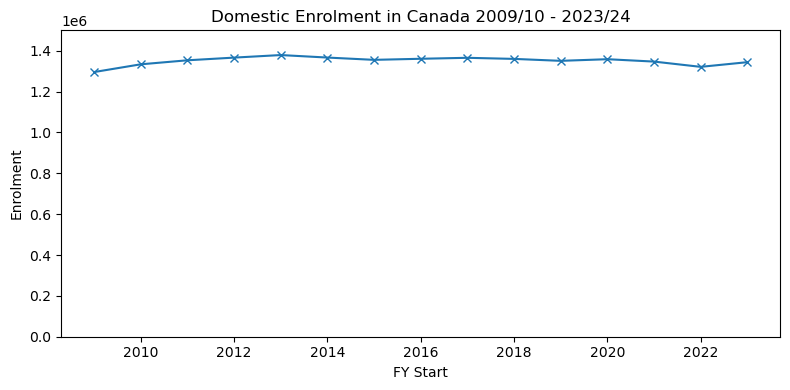

In [112]:
# plot Enrolment on y axis against FY start on x axis
plt.figure(figsize=(8, 4))
plt.plot(canada_dom['FY Start'], canada_dom['Enrolment'], marker='x')
plt.title('Domestic Enrolment in Canada 2009/10 - 2023/24')
plt.xlabel('FY Start')
plt.ylabel('Enrolment')
plt.ylim(0, 1500000)

plt.tight_layout()
plt.show()

## Domestic: Provincial enrolment 09/10 - 23/24

Start with filtering for only the total figures at the provincial level, graph the big provinces together & small ones separate for visibility

In [114]:
# Filter out records from Canada Domestic - only records with province (total) in Institution Name
provinces_df = processed_df[(processed_df['Canadian Status'] == 'Canadian students') & (processed_df['Institution Name'].str.contains(r'\(total\)')) & (processed_df['Province/Territory'] != 'Canada')]

Check the df - only Provincial totals

In [115]:
# Display the unique institution names - should only be provincial totals
print(f"{provinces_df['Institution Name'].unique()}\n\n")

# display the unique provinces - should only be provinces, no '(total)'
print(provinces_df['Province/Territory'].unique())

['Newfoundland and Labrador (total)' 'Prince Edward Island (total)'
 'Nova Scotia (total)' 'New Brunswick (total)' 'Quebec (total)'
 'Ontario (total)' 'Manitoba (total)' 'Saskatchewan (total)'
 'Alberta (total)' 'BC (total)' 'Yukon (total)'
 'Northwest Territories (total)' 'Nunavut (total)']


['Newfoundland and Labrador' 'Prince Edward Island' 'Nova Scotia'
 'New Brunswick' 'Quebec' 'Ontario' 'Manitoba' 'Saskatchewan' 'Alberta'
 'British Columbia' 'Yukon' 'Northwest Territories' 'Nunavut']


Plotting provinces in groups for scale with similar sized populations below:

In [117]:
from utils.constants import LARGE_POPULATION_PROVINCES, OTHER_PROVINCES, TERRITORIES

# Function to create a plotly figure for a group of provinces or territories
def create_interactive_plot(title, group_data, group_name):
    fig = go.Figure()

    for region in group_data[group_name].unique():
        region_data = group_data[group_data[group_name] == region]

        # Add line plot with markers
        fig.add_trace(go.Scatter(
            x=region_data['FY Start'],
            y=region_data['Enrolment'],
            mode='lines+markers',
            name=region,
            marker=dict(symbol='x', size=6)
        ))

    # Update layout to include a title, axis labels, and legend position
    fig.update_layout(
        title=title,
        xaxis_title="FY Start",
        yaxis_title="Enrolment",
        legend_title=group_name,
        legend=dict(
            orientation="v",
            x=1.05,  # Move legend outside the plotting area
            y=1,     # Align with top of the figure
        ),
        height=600,
        width=1300,
        margin=dict(l=50, r=150, t=50, b=50)
    )

    return fig

# Large provinces graph
large_provinces_fig = create_interactive_plot(
    "Domestic Enrolment 09/10 - 23/24 - Large Provinces",
    provinces_df[provinces_df['Province/Territory'].isin(LARGE_POPULATION_PROVINCES)],
    "Province/Territory"
)
large_provinces_fig.show()

# Other provinces graph
other_provinces_fig = create_interactive_plot(
    "Domestic Enrolment 09/10 - 23/24 - Other Provinces",
    provinces_df[provinces_df['Province/Territory'].isin(OTHER_PROVINCES)],
    "Province/Territory"
)
other_provinces_fig.show()

# Territories graph
territories_fig = create_interactive_plot(
    "Domestic Enrolment 09/10 - 23/24 - Territories",
    provinces_df[provinces_df['Province/Territory'].isin(TERRITORIES)],
    "Province/Territory"
)
territories_fig.show()

The domestic enrolment has been essentially flat in the last fourteen years. On an individual province level, we can see gentle declines in the Maritime provinces, slight growth in the Prairies and the largest provinces such as ON and BC effectively the same.

What is the share of domestic students among provinces?

In [118]:
# create a pie chart of provinces_df 2009 and 2022 Enrolment data
provinces_df_09_23 = provinces_df[provinces_df['FY Start'].isin([2009, 2023])]  # Filter for 2009 and 2023 data

# pie chart
fig = px.pie(
    provinces_df_09_23,
    names='Province/Territory',
    values='Enrolment',
    facet_col='FY Start', # splits by FY Start
    title='Domestic Enrolment in Canadian Provinces and Territories (2009 vs 2023)',
)

# fig.update_traces(textinfo='label+percent')  # Show province labels and percentages

# Display the plot
fig.show()

Barely any noticeable change in domestic student distribution across the provinces.
There is a modest 1.2% increase in Alberta, with a proportional decrease in share of domestic enrolment in QC mostly.

## Domestic: School-level enrolment 09/10 - 23/24

In [119]:
# Filter out records of provincial and national totals
psi_dom = processed_df[~processed_df['Institution Name'].str.contains(r'\(total\)') & (processed_df['Canadian Status'] == 'Canadian students')]

psi_dom

,FY Start,Province/Territory,Institution Name,Canadian Status,Enrolment
105,2009,Newfoundland and Labrador,Memorial U of Newfoundland,Canadian students,14298
106,2010,Newfoundland and Labrador,Memorial U of Newfoundland,Canadian students,14196
107,2011,Newfoundland and Labrador,Memorial U of Newfoundland,Canadian students,14097
108,2012,Newfoundland and Labrador,Memorial U of Newfoundland,Canadian students,13923
109,2013,Newfoundland and Labrador,Memorial U of Newfoundland,Canadian students,13611
...,...,...,...,...,...
10957,2019,Nunavut,Nunavut Arctic College,Canadian students,750
10958,2020,Nunavut,Nunavut Arctic College,Canadian students,843
10959,2021,Nunavut,Nunavut Arctic College,Canadian students,873
10960,2022,Nunavut,Nunavut Arctic College,Canadian students,783


In [35]:
# Check institution names greater than 40 characters - see how we can abbreviate them
long_institution_names = psi_dom[psi_dom['Institution Name'].str.len() > 40]
print(long_institution_names['Institution Name'].unique())

['Collège Communautaire du Nouveau-Brunswick'
 'New Brunswick College of Craft and Design'
 "École nationale d'administration publique"
 'Institut national de la recherche scientifique'
 'Champlain Regional College - Campus Saint-Lambert-Longueuil'
 "Institut de tourisme et d'hôtellerie du Québec"
 'École de sténographie judiciaire du Québec'
 'Collège dominicain de philosophie et de théologie'
 'Kemptville College of Agricultural Technology'
 'Providence U College and Theological Seminary'
 'Manitoba Institute of Trades and Technology']


In [36]:
import plotly.graph_objects as go

# Get the unique provinces/territories from the dataframe
unique_provinces = psi_dom['Province/Territory'].unique()

# Iterate over each province to create separate interactive graphs
for province in unique_provinces:
    # Filter the data for the current province/territory
    province_data = psi_dom[psi_dom['Province/Territory'] == province]

    # Filter Quebec data for enrolment >= 2000 to improve readability
    if province == "Quebec":
        province_data = province_data[province_data['Enrolment'] >= 2000]

    # Create a Plotly figure for the current province
    fig = go.Figure()

    # Plot enrolment trends for each school in the current province/territory
    for school in province_data['Institution Name'].unique():
        school_data = province_data[province_data['Institution Name'] == school]
        fig.add_trace(go.Scatter(
            x=school_data['FY Start'],
            y=school_data['Enrolment'],
            mode='lines+markers',
            name=school,
            marker=dict(symbol='x', size=6)
        ))

    # Set the title and labels
    fig.update_layout(
        title=f'Domestic Enrolment in {province}',
        xaxis_title='FY Start',
        yaxis_title='Enrolment',
        legend_title='Schools',
        legend=dict(
            orientation='v',
            x=1.05,  # Move legend outside the plotting area (right side)
            y=1,     # Align legend with the top of the figure
        ),
        height=600,
        width=1300,
        margin=dict(l=50, r=150, t=50, b=50)  # Adjust right margin to accommodate the legend
    )

    # Show the figure
    fig.show()

## International: Filter processed data above

Dec 2025 Update: No second data pipeline/processing needed as it was done above before the domestic/int'l split.

In [124]:
df_intl = processed_df[processed_df['Canadian Status'] == 'International students']

In [125]:
df_intl.sample(5)

,FY Start,Province/Territory,Institution Name,Canadian Status,Enrolment
4901,2009,Quebec,Collège Stanislas inc.,International students,36
7181,2013,Ontario,St. Lawrence College,International students,798
4421,2021,Quebec,Institut Teccart inc.,International students,468
10513,2019,British Columbia,Capilano U,International students,2532
4679,2009,Quebec,Campus Notre-Dame-de-Foy,International students,0


In [161]:
df_intl.shape

(3489, 5)

## International: Canada nationwide enrolment 09/10 - 23/24

In [126]:
# filter the dataframe for Canada national records only
canada_intl = df_intl[df_intl['Province/Territory'] == 'Canada']

In [127]:
canada_intl

,FY Start,Province/Territory,Institution Name,Canadian Status,Enrolment
30,2009,Canada,Canada (total),International students,105702
31,2010,Canada,Canada (total),International students,114072
32,2011,Canada,Canada (total),International students,127467
33,2012,Canada,Canada (total),International students,141675
34,2013,Canada,Canada (total),International students,160038
35,2014,Canada,Canada (total),International students,181086
36,2015,Canada,Canada (total),International students,195063
37,2016,Canada,Canada (total),International students,219018
38,2017,Canada,Canada (total),International students,254643
39,2018,Canada,Canada (total),International students,296061


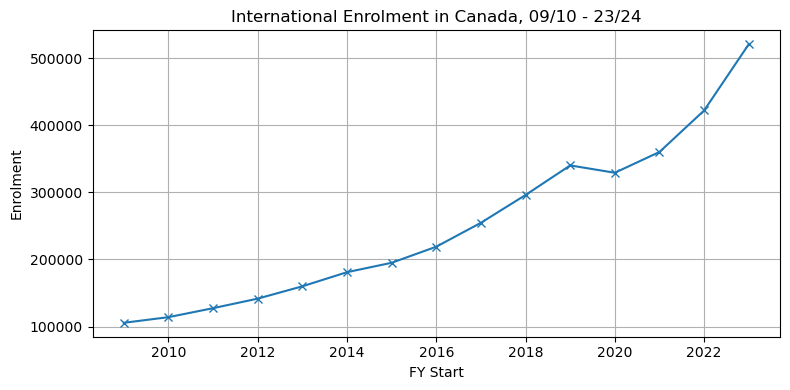

In [138]:
# plot Enrolment on y axis against FY start on x axis

plt.figure(figsize=(8, 4))
plt.plot(canada_intl['FY Start'], canada_intl['Enrolment'], marker='x')
plt.title('International Enrolment in Canada, 09/10 - 23/24')
plt.xlabel('FY Start')
plt.ylabel('Enrolment')
plt.grid(True)
plt.tight_layout()
plt.show()

**Compare this trend in International Enrolment vs Domestic Enrolment:**

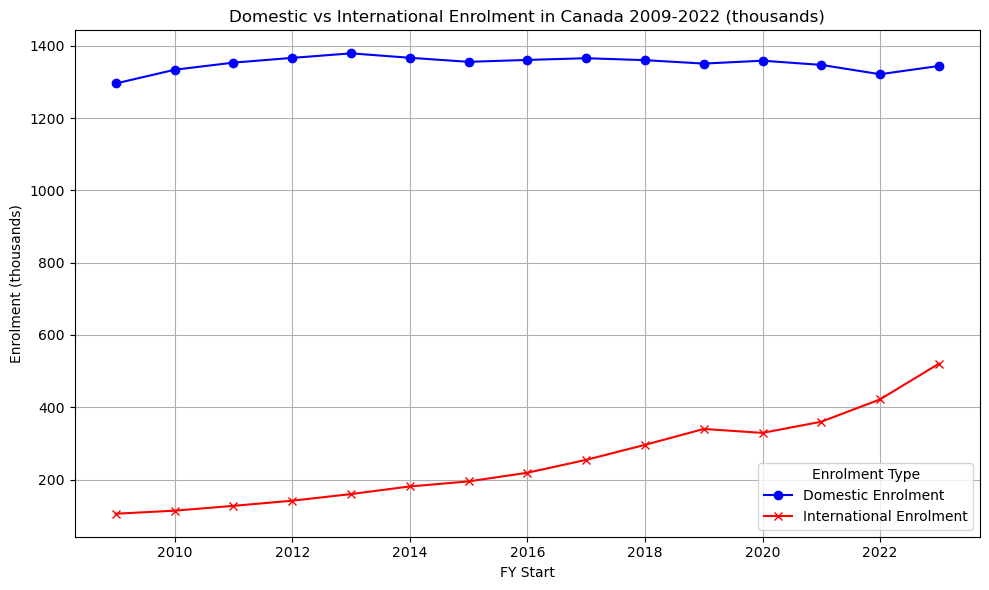

In [139]:
total_enrolment = canada_dom['Enrolment'].sum() + canada_intl['Enrolment'].sum()
intl_percentage = (canada_intl['Enrolment'].sum() / total_enrolment) * 100

# plot both domestic and international enrolment on the same graph
plt.figure(figsize=(10, 6))
plt.plot(
    canada_dom['FY Start'],
    canada_dom['Enrolment'] / 1000,
    marker='o',
    color='blue',
    label='Domestic Enrolment'
)
plt.plot(
    canada_intl['FY Start'],
    canada_intl['Enrolment'] / 1000,
    marker='x',
    color='red',
    label='International Enrolment'
)
plt.title('Domestic vs International Enrolment in Canada 2009-2022 (thousands)')
plt.xlabel('FY Start')
plt.ylabel('Enrolment (thousands)')
plt.legend(title='Enrolment Type')
plt.grid(True)
plt.tight_layout()
plt.show()

## International: Provincial enrolment 09/10 - 23/24

In [140]:
# Filter out records from Canada International - only records with province (total) in Institution Name
provinces_df_intl = df_intl[(df_intl['Institution Name'].str.contains(r'\(total\)')) & (df_intl['Province/Territory'] != 'Canada')]

In [141]:
provinces_df_intl

,FY Start,Province/Territory,Institution Name,Canadian Status,Enrolment
75,2009,Newfoundland and Labrador,Newfoundland and Labrador (total),International students,1080
76,2010,Newfoundland and Labrador,Newfoundland and Labrador (total),International students,1281
77,2011,Newfoundland and Labrador,Newfoundland and Labrador (total),International students,1389
78,2012,Newfoundland and Labrador,Newfoundland and Labrador (total),International students,1716
79,2013,Newfoundland and Labrador,Newfoundland and Labrador (total),International students,1785
...,...,...,...,...,...
10861,2020,Northwest Territories,Northwest Territories (total),International students,3
10862,2021,Northwest Territories,Northwest Territories (total),International students,0
10863,2022,Northwest Territories,Northwest Territories (total),International students,6
10864,2023,Northwest Territories,Northwest Territories (total),International students,3


Plotting change of international student enrolment over time by the provinces - split the large provinces from the others

In [142]:
print(provinces_df_intl['Province/Territory'].unique())

['Newfoundland and Labrador' 'Prince Edward Island' 'Nova Scotia'
 'New Brunswick' 'Quebec' 'Ontario' 'Manitoba' 'Saskatchewan' 'Alberta'
 'British Columbia' 'Yukon' 'Northwest Territories' 'Nunavut']


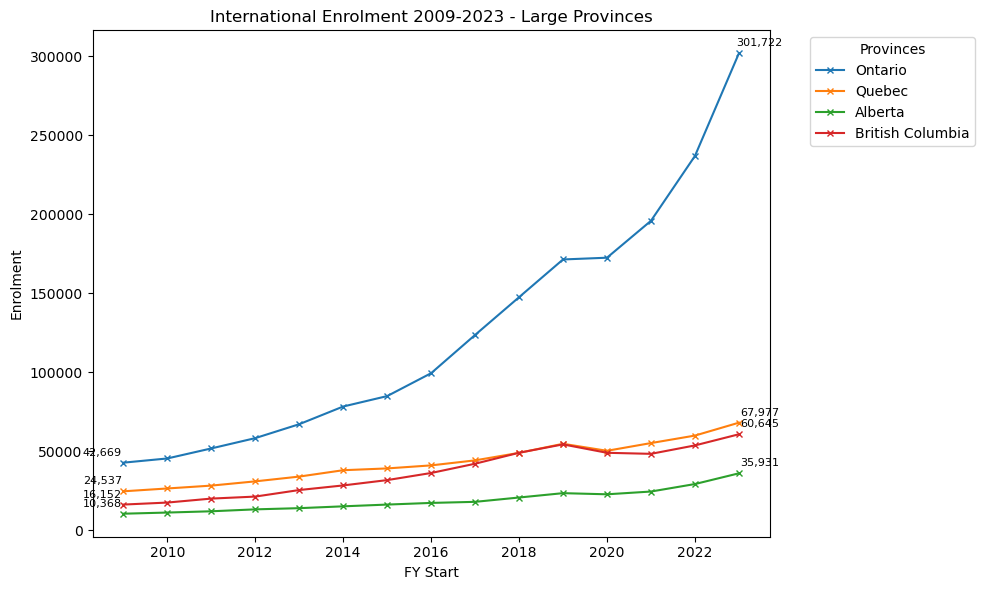

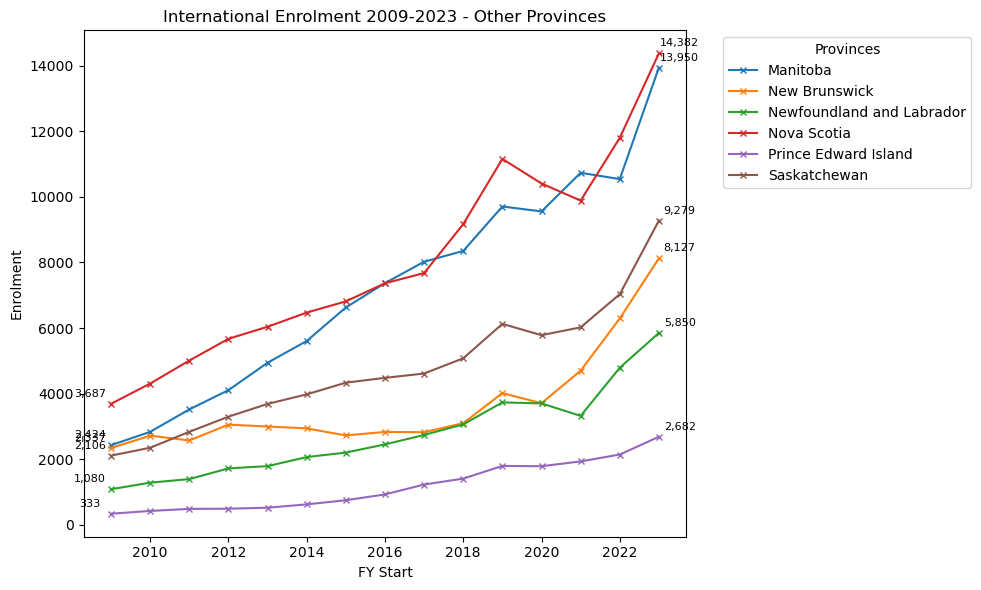

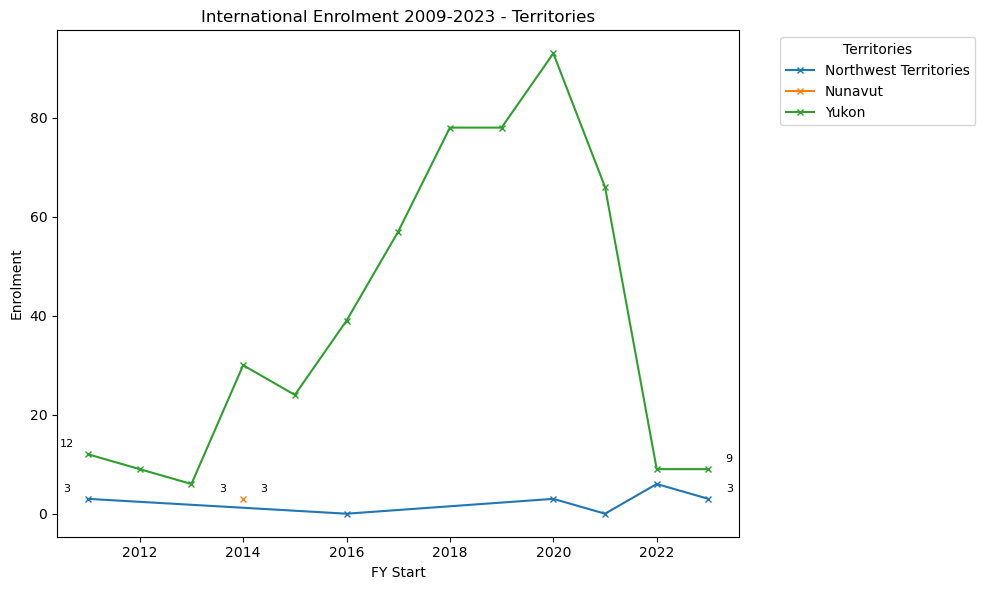

In [144]:
# Function to annotate the first and last y-values
def annotate_first_and_last_points(ax, x_data, y_data):
    if len(x_data) > 0 and len(y_data) > 0:
        # Annotate the first point
        ax.annotate(f'{y_data.iloc[0]:,.0f}', (x_data.iloc[0], y_data.iloc[0]), 
                    textcoords="offset points", xytext=(-15, 5), ha='center', fontsize=8)
        # Annotate the last point
        ax.annotate(f'{y_data.iloc[-1]:,.0f}', (x_data.iloc[-1], y_data.iloc[-1]), 
                    textcoords="offset points", xytext=(15, 5), ha='center', fontsize=8)

# Function to plot enrolment trends for a group of regions
def plot_enrolment_by_group(df, regions, title, y_label, legend_title):
    fig, ax = plt.subplots(figsize=(10, 6))
    for region in regions:
        region_data = df[df['Province/Territory'] == region]
        ax.plot(
            region_data['FY Start'],
            region_data['Enrolment'],
            label=region,
            marker='x',
            markersize=4
        )
        annotate_first_and_last_points(ax, region_data['FY Start'], region_data['Enrolment'])

    ax.set_title(title)
    ax.set_xlabel('FY Start')
    ax.set_ylabel(y_label)
    ax.legend(title=legend_title, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Call the function for each group of regions
plot_enrolment_by_group(
    provinces_df_intl, 
    LARGE_POPULATION_PROVINCES, 
    'International Enrolment 2009-2023 - Large Provinces', 
    'Enrolment', 
    'Provinces'
)

plot_enrolment_by_group(
    provinces_df_intl, 
    OTHER_PROVINCES, 
    'International Enrolment 2009-2023 - Other Provinces', 
    'Enrolment', 
    'Provinces'
)

plot_enrolment_by_group(
    provinces_df_intl, 
    TERRITORIES, 
    'International Enrolment 2009-2023 - Territories', 
    'Enrolment', 
    'Territories'
)

We will **ignore the territories from here on out** - there is no point analysing single digit student information.

Compare international student vs domestic student trends below:

In [145]:
from plotly.subplots import make_subplots

# Function to create interactive plots with consistent colors for regions
def compare_enrolment_plotly(domestic_df, intl_df, regions, title):
    fig = make_subplots(rows=1, cols=1)  # Single subplot, but this can be extended for multiple if needed

    # Generate a colormap for consistent colors
    colors = px.colors.qualitative.Set1  # Use a qualitative color set for distinct region colors
    region_colors = {region: colors[i % len(colors)] for i, region in enumerate(regions)}

    for region in regions:
        # Filter data for domestic and international enrolments
        domestic_data = domestic_df[domestic_df['Province/Territory'] == region]
        intl_data = intl_df[intl_df['Province/Territory'] == region]

        # Add domestic enrolment trace
        fig.add_trace(
            go.Scatter(
                x=domestic_data['FY Start'],
                y=domestic_data['Enrolment'],
                mode='lines+markers',
                name=f'{region} (Domestic)',
                line=dict(color=region_colors[region], dash='solid'),
                marker=dict(symbol='circle', size=6),
                hoverinfo='x+y+name',
            )
        )

        # Add international enrolment trace
        fig.add_trace(
            go.Scatter(
                x=intl_data['FY Start'],
                y=intl_data['Enrolment'],
                mode='lines+markers',
                name=f'{region} (International)',
                line=dict(color=region_colors[region], dash='dash'),
                marker=dict(symbol='x', size=6),
                hoverinfo='x+y+name',
            )
        )

    # Update layout for better readability
    fig.update_layout(
        title=title,
        xaxis_title='FY Start',
        yaxis_title='Enrolment',
        legend_title='Provinces/Status',
        template='plotly_white',
        hovermode='closest',
        width=900,
        height=600,
    )

    fig.show()

# Call the function for each group of regions
compare_enrolment_plotly(
    provinces_df, 
    provinces_df_intl, 
    LARGE_POPULATION_PROVINCES, 
    'Enrolment Trends 2009-2022 - Large Provinces (Domestic vs International)'
)

compare_enrolment_plotly(
    provinces_df, 
    provinces_df_intl, 
    OTHER_PROVINCES, 
    'Enrolment Trends 2009-2022 - Other Provinces (Domestic vs International)'
)

compare_enrolment_plotly(
    provinces_df, 
    provinces_df_intl, 
    TERRITORIES, 
    'Enrolment Trends 2009-2022 - Territories (Domestic vs International)'
)

## International: School-level Enrolment 09/10 - 23/24

In [162]:
# Filter out records of provincial and national totals
psi_intl = df_intl[~df_intl['Institution Name'].str.contains(r'\(total\)')]

psi_intl

,FY Start,Province/Territory,Institution Name,Canadian Status,Enrolment
120,2009,Newfoundland and Labrador,Memorial U of Newfoundland,International students,1038
121,2010,Newfoundland and Labrador,Memorial U of Newfoundland,International students,1230
122,2011,Newfoundland and Labrador,Memorial U of Newfoundland,International students,1341
123,2012,Newfoundland and Labrador,Memorial U of Newfoundland,International students,1650
124,2013,Newfoundland and Labrador,Memorial U of Newfoundland,International students,1725
...,...,...,...,...,...
10897,2020,Northwest Territories,Aurora College,International students,3
10898,2021,Northwest Territories,Aurora College,International students,0
10899,2022,Northwest Territories,Aurora College,International students,6
10900,2023,Northwest Territories,Aurora College,International students,3


In [163]:
# divide the dataframe by unique provinces and territories, except the territories
unique_provinces_intl = psi_intl['Province/Territory'].unique()

# remove Nunavut, Northwest Territories, and Yukon from the list
unique_provinces_intl = [province for province in unique_provinces_intl if province not in TERRITORIES]
print(TERRITORIES)
print(unique_provinces_intl)

['Northwest Territories', 'Nunavut', 'Yukon']
['Newfoundland and Labrador', 'Prince Edward Island', 'Nova Scotia', 'New Brunswick', 'Quebec', 'Ontario', 'Manitoba', 'Saskatchewan', 'Alberta', 'British Columbia']


In [164]:
# Iterate over each province to create separate interactive graphs
for province in unique_provinces_intl:
    # Filter the data for the current province/territory
    province_data = psi_intl[psi_intl['Province/Territory'] == province]

    # Filter Quebec data for enrolment >= 2000 to improve readability
    if province == "Quebec":
        province_data = province_data[province_data['Enrolment'] >= 2000]

    # Create a Plotly figure for the current province
    fig = go.Figure()

    # Plot enrolment trends for each school in the current province/territory
    for school in province_data['Institution Name'].unique():
        school_data = province_data[province_data['Institution Name'] == school]
        fig.add_trace(go.Scatter(
            x=school_data['FY Start'],
            y=school_data['Enrolment'],
            mode='lines+markers',
            name=school,
            marker=dict(symbol='x', size=6)
        ))

    # Update the layout to include titles, axis labels, and an external legend
    fig.update_layout(
        title=f'International Enrolment in {province}',
        xaxis_title="FY Start",
        yaxis_title="Enrolment",
        legend_title="Schools",
        legend=dict(
            orientation="v",
            x=1.05,  # Move legend outside the plotting area
            y=1      # Align with top of the figure
        ),
        height=600,
        width=1300,
        margin=dict(l=50, r=150, t=50, b=50)  # Adjust right margin for legend
    )

    # Show the figure
    fig.show()

## Year-on-Year Growth % Rates (Some cleaning still needed)

Beginning at national level we can find the year-on-year (YoY) growth rates for the international and domestic enrolment

Because of the impact of COVID on enrolment particularly in 2020/21 but also 21/22, we will split the last three years (20/21, 21/22 and 22/23) where appropriate.

### National YoY Enrolment Change

In [146]:
#show first 5 records of the canada_dom and canada_intl dataframe
print(canada_dom.head(), '\n\n', canada_intl.head())

    FY Start Province/Territory Institution Name    Canadian Status  Enrolment
15      2009             Canada   Canada (total)  Canadian students    1295745
16      2010             Canada   Canada (total)  Canadian students    1333629
17      2011             Canada   Canada (total)  Canadian students    1353324
18      2012             Canada   Canada (total)  Canadian students    1366443
19      2013             Canada   Canada (total)  Canadian students    1378959 

     FY Start Province/Territory Institution Name         Canadian Status  \
30      2009             Canada   Canada (total)  International students   
31      2010             Canada   Canada (total)  International students   
32      2011             Canada   Canada (total)  International students   
33      2012             Canada   Canada (total)  International students   
34      2013             Canada   Canada (total)  International students   

    Enrolment  
30     105702  
31     114072  
32     127467  
33

In [147]:
# plot domestic vs international enrolment for canada in plotly - TBC
fig = go.Figure()

# add domestic enrolment trace
fig.add_trace(go.Scatter(
    x=canada_dom['FY Start'],
    y=canada_dom['Enrolment'],
    mode='lines+markers',
    name='Domestic Enrolment',
    line=dict(color='blue', dash='solid'),
    marker=dict(symbol='circle', size=6),
    hoverinfo='x+y+name'
))

# add international enrolment trace
fig.add_trace(go.Scatter(
    x=canada_intl['FY Start'],
    y=canada_intl['Enrolment'],
    mode='lines+markers',
    name='International Enrolment',
    line=dict(color='red', dash='dash'),
    marker=dict(symbol='x', size=6),
    hoverinfo='x+y+name'
))

# update layout for better readability
fig.update_layout(
    title='Domestic vs International Enrolment in Canada',
    xaxis_title='FY Start',
    yaxis_title='Enrolment',
    legend_title='Enrolment Type',
    template='plotly_white',
    hovermode='closest',
    width=900,
    height=600
)

fig.show()

#### Exponential or Linear shape?

Is international enrolment more linear or exponential in nature?

For the whole 2009-2022 period:

In [149]:
# plot the growth with a linear regression line and R^2 value
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Linear regression
# Extract x and y values
x = canada_intl['FY Start'].values.reshape(-1, 1)  # FY Start as x (reshape for sklearn)
y = canada_intl['Enrolment'].values

# Linear regression
linear_model = LinearRegression()
linear_model.fit(x, y)
linear_pred = linear_model.predict(x)
linear_r2 = r2_score(y, linear_pred)

print(f"Linear fit of 09/10 - 23/24 data is {linear_r2:.3f}")

# Exponential
log_y = np.log(y)  # Transform y for exponential regression
exp_model = LinearRegression()
exp_model.fit(x, log_y)
exp_pred_log = exp_model.predict(x)
exp_pred = np.exp(exp_pred_log)  # Transform back to original scale
exp_r2 = r2_score(y, exp_pred)

print(f"Exponential fit of 09/10 - 23/24 data is {exp_r2:.3f}")

Linear fit of 09/10 - 23/24 data is 0.936
Exponential fit of 09/10 - 23/24 data is 0.983


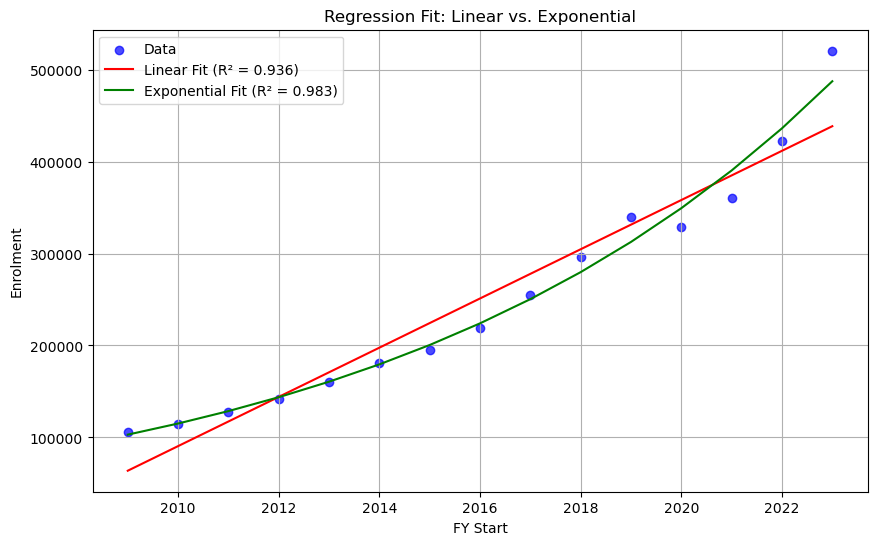

Linear R²: 0.936
Exponential R²: 0.983


In [150]:
# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(canada_intl['FY Start'], y, label="Data", color='blue', alpha=0.7)
plt.plot(canada_intl['FY Start'], linear_pred, label=f"Linear Fit (R² = {linear_r2:.3f})", color='red')
plt.plot(canada_intl['FY Start'], exp_pred, label=f"Exponential Fit (R² = {exp_r2:.3f})", color='green')
plt.xlabel('FY Start')
plt.ylabel('Enrolment')
plt.title('Regression Fit: Linear vs. Exponential')
plt.legend()
plt.grid()
plt.show()

# Results
print(f"Linear R²: {linear_r2:.3f}")
print(f"Exponential R²: {exp_r2:.3f}")

Isolate the 2020, 2021, 2022 data points, as COVID halted progress.

In [151]:
# create filter for pre-covid years and post-covid years
pre_covid_canada_intl = canada_intl[canada_intl['FY Start'] < 2020]
post_covid_canada_intl = canada_intl[canada_intl['FY Start'] >= 2020]

In [152]:
pre_covid_canada_intl.head()

,FY Start,Province/Territory,Institution Name,Canadian Status,Enrolment
30,2009,Canada,Canada (total),International students,105702
31,2010,Canada,Canada (total),International students,114072
32,2011,Canada,Canada (total),International students,127467
33,2012,Canada,Canada (total),International students,141675
34,2013,Canada,Canada (total),International students,160038


In [154]:
# model the pre-covid years
# Linear regression 
x = pre_covid_canada_intl['FY Start'].values.reshape(-1, 1)  # FY Start as x (reshape for sklearn)
y = pre_covid_canada_intl['Enrolment'].values

# Linear regression
linear_model = LinearRegression()
linear_model.fit(x, y)
linear_pred = linear_model.predict(x)
linear_r2 = r2_score(y, linear_pred)

print(f"Linear fit of Pre-Covid 09/10 - 19/20 data is {linear_r2:.3f}")

# Exponential
log_y = np.log(y)  # Transform y for exponential regression
exp_model = LinearRegression()
exp_model.fit(x, log_y)
exp_pred_log = exp_model.predict(x)
exp_pred = np.exp(exp_pred_log)  # Transform back to original scale
exp_r2 = r2_score(y, exp_pred)

print(f"Exponential fit of Pre-Covid 09/10 - 19/20 data is {exp_r2:.3f}")

Linear fit of Pre-Covid 09/10 - 19/20 data is 0.945
Exponential fit of Pre-Covid 09/10 - 19/20 data is 0.991


In [155]:
# model the post-covid years
# Linear regression 
x = post_covid_canada_intl['FY Start'].values.reshape(-1, 1)  # FY Start as x (reshape for sklearn)
y = post_covid_canada_intl['Enrolment'].values

# Linear regression
linear_model = LinearRegression()
linear_model.fit(x, y)
linear_pred = linear_model.predict(x)
linear_r2 = r2_score(y, linear_pred)

print(f"Linear fit of Post-Covid 20/21 - 23/24 data is {linear_r2:.3f}")

# Exponential
log_y = np.log(y)  # Transform y for exponential regression
exp_model = LinearRegression()
exp_model.fit(x, log_y)
exp_pred_log = exp_model.predict(x)
exp_pred = np.exp(exp_pred_log)  # Transform back to original scale
exp_r2 = r2_score(y, exp_pred)

print(f"Exponential fit of Post-Covid 20/21 - 23/24 data is {exp_r2:.3f}")

Linear fit of Post-Covid 20/21 - 23/24 data is 0.946
Exponential fit of Post-Covid 20/21 - 23/24 data is 0.972


As we can see in two cells above, the pre-covid years model much better for an exponential growth of international students before Covid-19 put a dent in enrolment but only temporarily, with just three Covid/post-Covid data points it is still more closely resembling the exponential model, just less so than pre-Covid,.

#### Growth rate YoY pre and post-covid

It's quite clear that Covid interrupted the growth rate so if we separate the data before (2009 - 2019) and after (2020 onwards) We can find year-on-year growth rates

In [156]:
pre_covid_canada_intl

,FY Start,Province/Territory,Institution Name,Canadian Status,Enrolment
30,2009,Canada,Canada (total),International students,105702
31,2010,Canada,Canada (total),International students,114072
32,2011,Canada,Canada (total),International students,127467
33,2012,Canada,Canada (total),International students,141675
34,2013,Canada,Canada (total),International students,160038
35,2014,Canada,Canada (total),International students,181086
36,2015,Canada,Canada (total),International students,195063
37,2016,Canada,Canada (total),International students,219018
38,2017,Canada,Canada (total),International students,254643
39,2018,Canada,Canada (total),International students,296061


In [157]:
# calculate year-on-year growth rates for the pre-covid and post-covid years
pre_covid_canada_intl['YOY Growth %'] = pre_covid_canada_intl['Enrolment'].pct_change() * 100
post_covid_canada_intl['YOY Growth %'] = post_covid_canada_intl['Enrolment'].pct_change() * 100


/var/folders/jj/bww8jnqd2lg73nm4k1z5kbmc0000gn/T/ipykernel_30718/964255350.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/jj/bww8jnqd2lg73nm4k1z5kbmc0000gn/T/ipykernel_30718/964255350.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



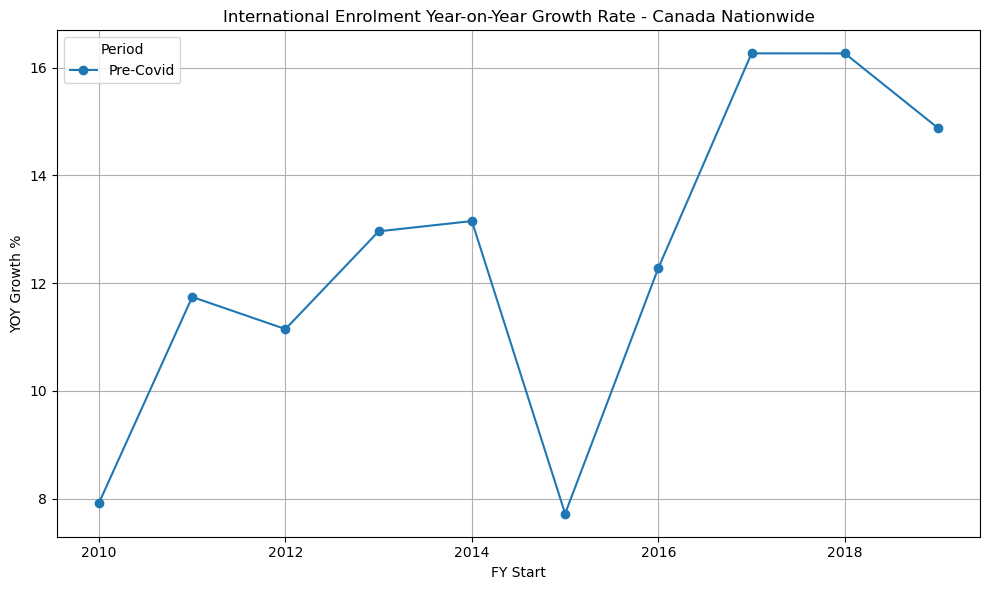

In [158]:
# plot year-on-year growth rates for the pre-covid and post-covid years
plt.figure(figsize=(10, 6))
plt.plot(pre_covid_canada_intl['FY Start'], pre_covid_canada_intl['YOY Growth %'], marker='o', label='Pre-Covid')
plt.title('International Enrolment Year-on-Year Growth Rate - Canada Nationwide')
plt.xlabel('FY Start')
plt.ylabel('YOY Growth %')
plt.legend(title='Period')
plt.grid(True)
plt.tight_layout()
plt.show()

In [159]:
post_covid_canada_intl

,FY Start,Province/Territory,Institution Name,Canadian Status,Enrolment,YOY Growth %
41,2020,Canada,Canada (total),International students,329172,NaN
42,2021,Canada,Canada (total),International students,360120,9.401772
43,2022,Canada,Canada (total),International students,421920,17.160946
44,2023,Canada,Canada (total),International students,520557,23.378129


The YoY growth rate of international students barely went below 8% once in the ten year period and in all but two years was 11% or above. Year-on-year double digit growth for a decade.

### Provinces YoY Enrolment Growth - Colleges vs Universities

There are a number of outliers in Year-on-Year growth rate (YOY) because of small institutions, and even then a small number of institutions in some territories, which are themselves small institutions, which will make these average calculations quite volatile without some tweaking.

We will **split the institutions up by colleges and universities** at the same time here.

First add the YoY growth column and then split the colleges from universities

In [165]:
# create YoY growth column for domestic and international enrolment
psi_dom['YOY Growth %'] = psi_dom.groupby('Institution Name')['Enrolment'].pct_change() * 100
psi_intl['YOY Growth %'] = psi_intl.groupby('Institution Name')['Enrolment'].pct_change() * 100

/var/folders/jj/bww8jnqd2lg73nm4k1z5kbmc0000gn/T/ipykernel_30718/2315664284.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/jj/bww8jnqd2lg73nm4k1z5kbmc0000gn/T/ipykernel_30718/2315664284.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [166]:
# Filter psi_intl for only College institutions - the word 'College', 'Polytechnic' or 'CC' or 'CÉGEP' in their name
college_intl = psi_intl[psi_intl['Institution Name'].str.contains(r'College|Polytechnic|CC|CÉGEP|Collège', regex=True)].fillna(0)
college_dom = psi_dom[psi_dom['Institution Name'].str.contains(r'College|Polytechnic|CC|CÉGEP|Collège', regex=True)].fillna(0)

# trim further - remove records with ' U ' or 'U ' in the name
college_intl = college_intl[~college_intl['Institution Name'].str.contains(r'(^U of | U of )', regex=True)]

# filter for Universities - all names that do not appear in the college_intl dataframe
univ_intl = psi_intl[~psi_intl['Institution Name'].isin(college_intl['Institution Name'])].fillna(0)
univ_dom = psi_dom[~psi_dom['Institution Name'].isin(college_dom['Institution Name'])].fillna(0)

/var/folders/jj/bww8jnqd2lg73nm4k1z5kbmc0000gn/T/ipykernel_30718/849808662.py:6: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.



**Retrospective comment:** As of Feb 10, individual PSIs on the graph with growth rates currently visualize poorly because there are one or two data points with very odd entries - usually where a change in data collection has led to 'international' being dramatically different one year and causing the subsequent YOY Growth % to appear as though it has crashed/exploded.

The aim of this section is to see if there is a meaningful difference between the enrolment change Year-on-Year between colleges and universities and we'll start that with an average instead, for a glance.

We will want to be careful with any outliers here which may skew the mean for a particular year

In [167]:
# Function to create a box plot
def plot_yoy_growth_boxplot(df, title):
    fig = px.box(
        df, 
        x="FY Start", 
        y="YOY Growth %",
        points="all",  # Show all outliers
        title=title
    )

    # Update layout
    fig.update_layout(
        xaxis_title="FY Start",
        yaxis_title="YOY Growth Rate (%)",
        height=500,
        width=800
    )

    # Show figure
    fig.show()

# Generate box plots for each dataset
plot_yoy_growth_boxplot(college_intl, "College International Enrolment YOY Growth %")
plot_yoy_growth_boxplot(college_dom, "College Domestic Enrolment YOY Growth %")
plot_yoy_growth_boxplot(univ_intl, "University International Enrolment YOY Growth %")
plot_yoy_growth_boxplot(univ_dom, "University Domestic Enrolment YOY Growth %")

There are going to be outliers in this data but the most egregious ones appear to be above 1000%. These data points can be replaced by the average of that year. 

It's noticeable that outliers for international growth rates are much larger than for domestic students. Several probable reasons for this:
- Math: Many schools have low international student base in the early 2010s. 200 new international students next year could be 50% growth on the previous year, likely not the case in domestic enrolment for an established school.
- Demographics: It's very hard to suddenly recruit twice as many domestic students in one year - domestic students are an 18-year demographic pipelinem (for undergrad straight from HS).
- Operational: I suspect due to occasional admin changes in data collection may change how international student numbers get reported, could easily make an administrative 0 or handful of 'other' become many the following year.

Below are functions to remove records where growth rates were over 1000% and institutions with less than 250 enrolment, likely the biggest sources of extreme outliers

In [168]:
def clean_dataset_for_provincial_avg(df, enrolment_threshold=200, yoy_threshold=1000):
    """
    Excludes rows with Enrolment < 250 or YOY Growth > 1000.
    Infinity is treated as NaN, which gets excluded as well.
    """
    df = df.copy()

    # Replace infinity values with NaN
    df['YOY Growth %'].replace([np.inf, -np.inf], np.nan, inplace=True)

    # Exclude rows with low enrolment or extreme YOY Growth
    df = df[
        (df['Enrolment'] >= enrolment_threshold) &
        (df['YOY Growth %'] <= yoy_threshold) &
        (~df['YOY Growth %'].isna())  # Exclude NaN
    ]

    return df

In [169]:
def compute_provincial_avg(df):
    """
    Groups by Province/Territory and FY Start,
    computes average YOY Growth and count of records.
    """
    grouped = (
        df.groupby(['Province/Territory', 'FY Start'])['YOY Growth %']
        .agg(['mean', 'count'])  # mean is average YOY, count is # of institutions
        .reset_index()
        .rename(columns={'mean': 'Avg_YOY_Growth', 'count': 'Num_Institutions'})
    )
    return grouped

In [170]:
def plot_provincial_growth(college_df, univ_df, provinces, title_prefix):
    """
    Creates one figure per province comparing average YOY Growth
    for Colleges vs. Universities (International or Domestic).
    """
    # Determine the max year for consistent X-axis
    max_year = max(college_df['FY Start'].max(), univ_df['FY Start'].max())

    for province in provinces:
        # Filter data
        college_data = college_df[college_df['Province/Territory'] == province]
        univ_data = univ_df[univ_df['Province/Territory'] == province]

        fig = go.Figure()

        # Colleges line
        fig.add_trace(go.Scatter(
            x=college_data['FY Start'],
            y=college_data['Avg_YOY_Growth'],
            mode='lines+markers',
            name='Colleges',
            text=college_data['Num_Institutions'],  # This will show # of institutions in hover
            hovertemplate=(
                'FY Start: %{x}<br>'
                'Avg Growth: %{y:.2f}%<br>'
                'Num Institutions: %{text}<extra></extra>'
            ),
            line=dict(color='blue', width=2)
        ))

        # Universities line
        fig.add_trace(go.Scatter(
            x=univ_data['FY Start'],
            y=univ_data['Avg_YOY_Growth'],
            mode='lines+markers',
            name='Universities',
            text=univ_data['Num_Institutions'],
            hovertemplate=(
                'FY Start: %{x}<br>'
                'Avg Growth: %{y:.2f}%<br>'
                'Num Institutions: %{text}<extra></extra>'
            ),
            line=dict(color='red', width=2)
        ))

        # Horizontal reference line at 0% growth
        fig.add_shape(
            type="line",
            x0=2009,
            x1=max_year,
            y0=0, y1=0,
            line=dict(color="black", width=2, dash="dash"),
            name="0% Growth Line"
        )

        fig.update_layout(
            title=f'{title_prefix} in {province}: Average YOY Growth %',
            xaxis_title='FY Start',
            yaxis_title='Average YOY Growth (%)',
            legend_title='Institution Type',
            xaxis=dict(range=[2009, max_year]),
            height=600,
            width=1000
        )

        fig.show()

In [171]:
from utils.constants import PROVINCES

# 1. Cleaning Data
# ---------------------------
college_intl_clean = clean_dataset_for_provincial_avg(college_intl, enrolment_threshold=250, yoy_threshold=1000)
univ_intl_clean = clean_dataset_for_provincial_avg(univ_intl, enrolment_threshold=250, yoy_threshold=1000)

# create these for later, but not used in this example
college_dom_clean = clean_dataset_for_provincial_avg(college_dom, enrolment_threshold=250, yoy_threshold=1000)
univ_dom_clean = clean_dataset_for_provincial_avg(univ_dom, enrolment_threshold=250, yoy_threshold=1000)

# 2. Computing Provincial Averages
# ---------------------------
college_intl_avg = compute_provincial_avg(college_intl_clean)
univ_intl_avg = compute_provincial_avg(univ_intl_clean)
college_dom_avg = compute_provincial_avg(college_dom_clean)
univ_dom_avg = compute_provincial_avg(univ_dom_clean)

# Only keep desired provinces (e.g., BC, ON, AB) or derive from your data

# 3. Plotting
# ---------------------------
plot_provincial_growth(
    college_df=college_intl_avg,
    univ_df=univ_intl_avg,
    provinces=PROVINCES,
    title_prefix="International Students"
)

/var/folders/jj/bww8jnqd2lg73nm4k1z5kbmc0000gn/T/ipykernel_30718/1019171455.py:9: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





The number of institutions in hover-over shows how volatile the figures are with low sample sizes, which is why I removed PEI and NL from these visuals.

The most reliable (and relevant, to see the number of institutions and their activity) provinces to look at are AB, BC and ON with larger sample sizes, and volatilty is greater among Colleges than Universities. Growth was much more explosive, particularly in the late 2010s with 20 institutions giving up to 70% growth YoY in some years.

Now with cleaned data we can make an aggregate for colleges and universities, domestic and international.

In [172]:
def clean_and_aggregate(df, enrolment_threshold=250, yoy_threshold=500):
    """
    1) Excludes rows where Enrolment < 250 or YOY Growth > 500 or is inf/NaN.
    2) Groups by FY Start and returns:
       - Mean YOY Growth (column: 'Avg_YOY_Growth')
       - Count of rows (column: 'Num_Institutions')
    """

    df = df.copy()

    # Replace infinities with NaN
    df['YOY Growth %'].replace([np.inf, -np.inf], np.nan, inplace=True)

    # Exclude small enrolment, extreme YOY Growth, or NaN
    df = df[
        (df['Enrolment'] >= enrolment_threshold)
        & (df['YOY Growth %'] <= yoy_threshold)
        & (~df['YOY Growth %'].isna())
    ]

    # Group by FY Start, compute mean YOY Growth and count
    aggregated = (
        df.groupby('FY Start')
          .agg(Avg_YOY_Growth=('YOY Growth %', 'mean'),
               Num_Institutions=('YOY Growth %', 'count'))
          .reset_index()
    )

    return aggregated

# Aggregate each dataset (College/University, Domestic/International)
college_intl_avg = clean_and_aggregate(college_intl)
college_dom_avg  = clean_and_aggregate(college_dom)
univ_intl_avg    = clean_and_aggregate(univ_intl)
univ_dom_avg     = clean_and_aggregate(univ_dom)

/var/folders/jj/bww8jnqd2lg73nm4k1z5kbmc0000gn/T/ipykernel_30718/902995370.py:12: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/var/folders/jj/bww8jnqd2lg73nm4k1z5kbmc0000gn/T/ipykernel_30718/902995370.py:12: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing '

In [173]:
college_intl_avg

,FY Start,Avg_YOY_Growth,Num_Institutions
0,2009,0.000000,17
1,2010,20.583940,16
2,2011,18.059071,20
3,2012,18.432372,18
4,2013,25.823445,18
5,2014,21.132489,26
6,2015,28.337691,31
7,2016,54.332692,35
8,2017,45.963177,37
9,2018,45.625209,44


### **CLEANED VIEW** Aggregate view of YoY Growth: Colleges / Universities

In [174]:
fig = go.Figure()

# 1) College International
fig.add_trace(go.Scatter(
    x=college_intl_avg['FY Start'],
    y=college_intl_avg['Avg_YOY_Growth'],
    mode='lines+markers',
    name='College International',
    line=dict(color='blue', dash='solid', width=2),
    marker=dict(size=6),
    # Provide the number of institutions in the 'text' attribute for hover
    text=college_intl_avg['Num_Institutions'],
    hovertemplate=(
        'FY Start: %{x}<br>'
        'Avg Growth: %{y:.2f}%<br>'
        'Num Institutions: %{text}<extra></extra>'
    )
))

# 2) College Domestic
fig.add_trace(go.Scatter(
    x=college_dom_avg['FY Start'],
    y=college_dom_avg['Avg_YOY_Growth'],
    mode='lines+markers',
    name='College Domestic',
    line=dict(color='blue', dash='dash', width=2),
    marker=dict(size=6),
    text=college_dom_avg['Num_Institutions'],
    hovertemplate=(
        'FY Start: %{x}<br>'
        'Avg Growth: %{y:.2f}%<br>'
        'Num Institutions: %{text}<extra></extra>'
    )
))

# 3) University International
fig.add_trace(go.Scatter(
    x=univ_intl_avg['FY Start'],
    y=univ_intl_avg['Avg_YOY_Growth'],
    mode='lines+markers',
    name='University International',
    line=dict(color='red', dash='solid', width=2),
    marker=dict(size=6),
    text=univ_intl_avg['Num_Institutions'],
    hovertemplate=(
        'FY Start: %{x}<br>'
        'Avg Growth: %{y:.2f}%<br>'
        'Num Institutions: %{text}<extra></extra>'
    )
))

# 4) University Domestic
fig.add_trace(go.Scatter(
    x=univ_dom_avg['FY Start'],
    y=univ_dom_avg['Avg_YOY_Growth'],
    mode='lines+markers',
    name='University Domestic',
    line=dict(color='red', dash='dash', width=2),
    marker=dict(size=6),
    text=univ_dom_avg['Num_Institutions'],
    hovertemplate=(
        'FY Start: %{x}<br>'
        'Avg Growth: %{y:.2f}%<br>'
        'Num Institutions: %{text}<extra></extra>'
    )
))

# Determine global min/max of FY Start for the 0% reference line
x_min = min(df['FY Start'].min() for df in [college_intl_avg, college_dom_avg, univ_intl_avg, univ_dom_avg] if not df.empty)
x_max = max(df['FY Start'].max() for df in [college_intl_avg, college_dom_avg, univ_intl_avg, univ_dom_avg] if not df.empty)

# Add a 0% Growth reference line
fig.add_shape(
    type='line',
    x0=x_min, x1=x_max,
    y0=0,     y1=0,
    line=dict(color="black", dash="dash", width=2),
    name="0% Growth"
)

fig.update_layout(
    title='Average YOY Growth Rates: Colleges vs. Universities (Domestic & International)',
    xaxis_title='FY Start',
    yaxis_title='Average YOY Growth Rate (%)',
    legend_title='Institution Type',
    width=1000,
    height=600
)

fig.show()

**Now it is easier to see the general behaviour**.

As with the higher-level data, international enrolment is driving virtually all enrolment growth in PSIs across Canada, but even removing the smallest institutions to avoid skew, the college data is significantly more volatile. Neither universities or colleges seem to have any years of single digit international growth except for Universities in 2021, recovering from the pandemic.

The recovery from Covid was much more rapid for Colleges, the growth years were twice (or more) as strong, and the 'down years' were much more significantly down than in universities.

There isn't much to tell apart from the domestic enrolment data, other than they have stayed more or less equivalent. There may be something in the noticeable growth for 2013 for both categories if it is largely a product of first-year undergraduate programs having larger enrolment (is there census-level data indicating more births in 1995 than 1994 or 1993 --> more 18 year olds in 2013 than 2012 or 2011?)

### Individual schools YoY Enrolment Growth Rates:


We've cleaned some of the most egregious growth rate values out now, let's try to plot individual schools.

We have `college_intl_clean` and `univ_intl_clean` from the plotting in the previous section - no <250 enrolment or >1000% YoY growth outliers

Important to remember that although there are still some very skewed data points, the hover-over shows the school, enrolment this year **and** the YoY growth figure so it is enough context to explain any massive triple-digit growth rates that appear

In [186]:
college_intl_clean.describe()

,FY Start,Enrolment,YOY Growth %
count,508.000000,508.000000,508.000000
mean,2017.673228,2345.515748,32.159709
std,4.006345,2770.404228,52.847576
min,2009.000000,252.000000,-48.857143
25%,2015.000000,551.250000,3.979765
50%,2018.000000,1303.500000,20.763234
75%,2021.000000,3210.750000,43.853405
max,2023.000000,27786.000000,460.000000


In [187]:
college_intl_clean

,FY Start,Province/Territory,Institution Name,Canadian Status,Enrolment,YOY Growth %
175,2019,Newfoundland and Labrador,College of the North Atlantic,International students,309,255.172414
176,2020,Newfoundland and Labrador,College of the North Atlantic,International students,393,27.184466
177,2021,Newfoundland and Labrador,College of the North Atlantic,International students,300,-23.664122
178,2022,Newfoundland and Labrador,College of the North Atlantic,International students,363,21.000000
179,2023,Newfoundland and Labrador,College of the North Atlantic,International students,624,71.900826
...,...,...,...,...,...,...
10693,2019,British Columbia,Kwantlen Polytechnic U,International students,3075,-21.093149
10694,2020,British Columbia,Kwantlen Polytechnic U,International students,3225,4.878049
10695,2021,British Columbia,Kwantlen Polytechnic U,International students,4662,44.558140
10696,2022,British Columbia,Kwantlen Polytechnic U,International students,5703,22.329472


In [189]:
# List of territories to exclude
territories = ["Nunavut", "Northwest Territories", "Yukon"]

# Define institution types and their datasets
institution_types = {
    "Colleges": {"intl students": college_intl_clean},
    "Universities": {"intl students": univ_intl_clean}
}

# Iterate over each institution type (Colleges & Universities)
for inst_type, datasets in institution_types.items():
    for dataset_name, df in datasets.items():
        
        # Get unique provinces (excluding territories)
        unique_provinces = sorted(df['Province/Territory'].unique())
        unique_provinces = [p for p in unique_provinces if p not in territories]

        # Iterate over each province to create a separate line plot
        for province in unique_provinces:
            # Filter the data for the current province
            province_data = df[df['Province/Territory'] == province]

            # Create a Plotly figure for the province
            fig = go.Figure()

            # Add lines for each institution
            for school in province_data['Institution Name'].unique():
                school_data = province_data[province_data['Institution Name'] == school]

                fig.add_trace(go.Scatter(
                    x=school_data['FY Start'],
                    y=school_data['YOY Growth %'],
                    mode='lines+markers',
                    name=school,  # Institution name in legend
                    marker=dict(size=6),
                    line=dict(width=2),

                    # Pass Enrolment to 'text'
                    text=school_data['Enrolment'],

                    # Include institution name, FY Start, YOY Growth, and Enrolment in hover
                    hovertemplate=(
                        f"School: {school}<br>"     # Insert the current loop's school name
                        "FY Start: %{x}<br>"
                        "YOY Growth %: %{y:.2f}%<br>"
                        "Enrolment: %{text}<br>"
                        "<extra></extra>"
                    )
                ))

            # Add a horizontal reference line at 0% YOY Growth
            fig.add_shape(
                type="line",
                x0=province_data['FY Start'].min(),
                x1=province_data['FY Start'].max(),
                y0=0, y1=0,
                line=dict(color="black", width=2, dash="dash"),
                name="0% Growth Line"
            )

            # Update layout
            fig.update_layout(
                title=f'YOY Growth Rate of {inst_type} ({dataset_name.capitalize()}) in {province}',
                xaxis_title="FY Start",
                yaxis_title="YOY Growth Rate (%)",
                legend_title="Institutions",
                legend=dict(
                    orientation="v",  # Vertical legend
                    x=1.05,           # Move legend outside the plot
                    y=1
                ),
                height=600,
                width=1300,
                margin=dict(l=50, r=200, t=50, b=50),
                # Fix X-axis from 2009 to 2023 with +1 year buffer with annual ticks
                xaxis=dict(
                    range=[2008, 2024],
                    dtick=1  # Show a tick for every year
                )
            )

            # Show the figure
            fig.show()

## Provincial-level international student % of enrolment

Goal is to identify institutions that may be particularly dependent on international enrolment. 

We'll start by combining the international and domestic figures for each school in a given year using `psi_intl` and `psi_dom`

In [190]:
psi_intl.sample(2)

,FY Start,Province/Territory,Institution Name,Canadian Status,Enrolment,YOY Growth %
9354,2012,Alberta,Red Deer Polytechnic,International students,60,33.333333
5319,2023,Quebec,Collège TAV,International students,405,6.299213


In [198]:
psi_dom.sample(2)

,FY Start,Province/Territory,Institution Name,Canadian Status,Enrolment,YOY Growth %
3733,2022,Quebec,Cégep de Sorel-Tracy,Canadian students,1002,-4.297994
6123,2023,Ontario,U of Windsor,Canadian students,11169,1.527134


### Pivot the tables to combine international & Domestic enrolment for the % calculation

In [199]:
from utils.constants import TERRITORIES

# Step 1: Filter out territories from colleges_universities_df and include 'Province/Territory' in the index
domestic_df = psi_dom[
    (psi_dom['Canadian Status'] == 'Canadian students') &
    (~psi_dom['Province/Territory'].isin(TERRITORIES))
].pivot_table(
    index=['Institution Name', 'Province/Territory', 'FY Start'],
    values='Enrolment',
    aggfunc='sum'
).reset_index()

# Rename the 'Enrolment' column to 'Domestic Enrolment'
domestic_df.rename(columns={'Enrolment': 'Domestic Enrolment'}, inplace=True)

# Step 2: Filter out territories from colleges_universities_df_intl and include 'Province/Territory' in the index
international_df = psi_intl[
    (psi_intl['Canadian Status'] == 'International students') &
    (~psi_intl['Province/Territory'].isin(TERRITORIES))
].pivot_table(
    index=['Institution Name', 'Province/Territory', 'FY Start'],
    values='Enrolment',
    aggfunc='sum'
).reset_index()

# Rename the 'Enrolment' column to 'International Enrolment'
international_df.rename(columns={'Enrolment': 'International Enrolment'}, inplace=True)

# Step 3: Join the two DataFrames on 'School Name', 'Province/Territory', and 'FY Start'
combined_df = pd.merge(
    domestic_df,
    international_df,
    on=['Institution Name', 'Province/Territory', 'FY Start'],
    how='outer'
)

#replace nulls with 0
combined_df.fillna(0, inplace=True)

# Display the combined DataFrame
print(combined_df)

               Institution Name Province/Territory  FY Start  \
0                      Acadia U        Nova Scotia      2009   
1                      Acadia U        Nova Scotia      2010   
2                      Acadia U        Nova Scotia      2011   
3                      Acadia U        Nova Scotia      2012   
4                      Acadia U        Nova Scotia      2013   
...                         ...                ...       ...   
3477  École nationale de Cirque             Quebec      2019   
3478  École nationale de Cirque             Quebec      2020   
3479  École nationale de Cirque             Quebec      2021   
3480  École nationale de Cirque             Quebec      2022   
3481  École nationale de Cirque             Quebec      2023   

      Domestic Enrolment  International Enrolment  
0                 2667.0                    372.0  
1                 2727.0                    360.0  
2                 2976.0                    372.0  
3                 3135.

In [200]:
combined_df.sample(4)

,Institution Name,Province/Territory,FY Start,Domestic Enrolment,International Enrolment
1302,Cégep de Saint-Hyacinthe,Quebec,2012,4176.0,33.0
1531,Cégep du Vieux Montréal,Quebec,2016,6105.0,192.0
14,Acadia U,Nova Scotia,2023,3087.0,489.0
3123,U of King's College,Nova Scotia,2022,837.0,42.0


In [223]:
combined_df[(combined_df['Province/Territory'].isin(['British Columbia', 'Alberta'])) & (combined_df['FY Start'] == 2023)]

,Institution Name,Province/Territory,FY Start,Domestic Enrolment,International Enrolment,Francophone,% International
29,Alberta U of the Arts,Alberta,2023,1089,96,0,8.10
74,Ambrose U,Alberta,2023,495,39,0,7.30
104,Athabasca U,Alberta,2023,7074,237,0,3.24
134,BC Institute of Technology,British Columbia,2023,9087,2331,0,20.42
175,Bow Valley College,Alberta,2023,5646,2460,0,30.35
220,Burman U,Alberta,2023,252,69,0,21.50
250,Camosun College,British Columbia,2023,4365,1971,0,31.11
325,Capilano U,British Columbia,2023,3120,3900,0,55.56
400,Coast Mountain College,British Columbia,2023,234,489,0,67.63
415,College of New Caledonia,British Columbia,2023,1092,1386,0,55.93


In [225]:
combined_df[(combined_df['Province/Territory'].isin(['British Columbia', 'Alberta'])) & (combined_df['FY Start'] == 2020)]

,Institution Name,Province/Territory,FY Start,Domestic Enrolment,International Enrolment,Francophone,% International
26,Alberta U of the Arts,Alberta,2020,972,90,0,8.47
71,Ambrose U,Alberta,2020,555,24,0,4.15
101,Athabasca U,Alberta,2020,7656,246,0,3.11
131,BC Institute of Technology,British Columbia,2020,9348,3021,0,24.42
172,Bow Valley College,Alberta,2020,4749,1506,0,24.08
217,Burman U,Alberta,2020,282,87,0,23.58
247,Camosun College,British Columbia,2020,4680,1191,0,20.29
322,Capilano U,British Columbia,2020,3306,2142,0,39.32
397,Coast Mountain College,British Columbia,2020,273,258,0,48.59
412,College of New Caledonia,British Columbia,2020,1134,1260,0,52.63


In [227]:
# display all institutions for the years 2020 to 2023
last_four_yrs = combined_df[(combined_df['FY Start'] >= 2020) & (combined_df['FY Start'] <= 2023)].sort_values(by=['Province/Territory', 'Institution Name', 'FY Start'])

In [228]:
# save the above dataframe to a csv file
last_four_yrs.to_csv('institution_enrolment_2020_2023.csv', index=False)



### Francophone

Including exceptions: Anglophone QC like McGill and Concordia, Francophone outside QC.

In [201]:
# 1. Lists of known schools
francophone_schools = [
    "U Sainte-Anne", "Collège Boréal", "Collège d'Alfred", 
    "Collège dominicain", "La Cité collégiale", "U de Hearst", 
    "U de l'Ontario français", "U de Moncton", 
    "Collège Communautaire du Nouveau-Brunswick", "Collège de l'Île", 
    "L'École Technique et Professionnelle"
]

english_exceptions_in_quebec = [
    "McGill U", "Bishop's U", "Concordia U", "Vanier College",
    "John Abbott College", "Heritage College", "Dawson College"
]

# 2. Define a function to decide if a row is Francophone
def is_francophone(row):
    inst_name = row['Institution Name']
    province = row['Province/Territory']

    # A) If outside Quebec, mark as Francophone only if it appears in the francophone_schools list
    if province != "Quebec":
        if any(fr_school in inst_name for fr_school in francophone_schools):
            return 1
        else:
            return 0
    
    # B) If inside Quebec:
    #    It's Francophone unless the institution matches an English exception.
    if any(eng_exc in inst_name for eng_exc in english_exceptions_in_quebec):
        return 0
    else:
        return 1

# 3. Apply the function to your dataframe
combined_df['Francophone'] = combined_df.apply(is_francophone, axis=1)


# Display the updated DataFrame
print(combined_df[['Institution Name', 'Province/Territory', 'Francophone']].sample(4))

                      Institution Name Province/Territory  Francophone
2403                  Okanagan College   British Columbia            0
2782           Séminaire de Sherbrooke             Quebec            1
2210                       Nipissing U            Ontario            0
664   Collège O'Sullivan de Québec inc             Quebec            1


### Calculating School & Province's % International figures

In [202]:
# create a domestic/international ratio column
combined_df['% International'] = round((combined_df['International Enrolment'] / (combined_df['Domestic Enrolment'] + combined_df['International Enrolment'])) * 100, 2)

In [203]:
combined_df[(combined_df['Francophone'] == 0) & (combined_df['Province/Territory'] == 'Quebec')]

,Institution Name,Province/Territory,FY Start,Domestic Enrolment,International Enrolment,Francophone,% International
135,Bishop's U,Quebec,2009,1623.0,243.0,0,13.02
136,Bishop's U,Quebec,2010,1812.0,279.0,0,13.34
137,Bishop's U,Quebec,2011,1998.0,297.0,0,12.94
138,Bishop's U,Quebec,2012,2109.0,339.0,0,13.85
139,Bishop's U,Quebec,2013,2118.0,342.0,0,13.90
...,...,...,...,...,...,...,...
2019,McGill U,Quebec,2019,21939.0,11406.0,0,34.21
2020,McGill U,Quebec,2020,22617.0,10833.0,0,32.39
2021,McGill U,Quebec,2021,22938.0,10551.0,0,31.51
2022,McGill U,Quebec,2022,23319.0,10713.0,0,31.48


In [204]:
# check any suspicious values e.g. 99 or 100% perhaps a mis calculation
combined_df['% International'].sort_values(ascending=False)

153     100.00
751      93.33
752      92.86
44       88.36
2279     87.54
         ...  
537       0.00
878       0.00
877       0.00
876       0.00
2364      0.00
Name: % International, Length: 3482, dtype: float64

In [205]:
# check what the 100% international figure is
combined_df[combined_df['% International'] == 100]

,Institution Name,Province/Territory,FY Start,Domestic Enrolment,International Enrolment,Francophone,% International
153,Booth U College,Manitoba,2015,0.0,9.0,0,100.0


In [206]:
# remove the above record as it is likely a mis-calculation
combined_df = combined_df[combined_df['% International'] < 100]

Next Steps: Create provincial averages and totals - goal to compare individual institutions against the provincial standards.

In [207]:
# Mapping of full province names to their codes - easier to read
province_codes = {
    "British Columbia": "BC",
    "Alberta": "AB",
    "Ontario": "ON",
    "Prince Edward Island": "PEI",
    "New Brunswick": "NB",
    "Nova Scotia": "NS",
    "Saskatchewan": "SK",
    "Manitoba": "MB",
    "Quebec": "QC",
    "Newfoundland and Labrador": "NL"
}

# Make a copy of the existing combined_df to add new records
new_records = []

# Get unique provinces and fiscal years - all ten provinces from 2011 to 2021
provinces = combined_df['Province/Territory'].unique()
fiscal_years = combined_df['FY Start'].unique()

# Iterate over each province and fiscal year to calculate totals and averages for Francophone and English PSIs
for province in provinces:
    for fy in fiscal_years:
        # Filter the data for the current province and fiscal year
        province_data = combined_df[
            (combined_df['Province/Territory'] == province) & (combined_df['FY Start'] == fy)
        ]

        # Split the data into Francophone and non-Francophone
        fr_data = province_data[province_data['Francophone'] == 1]
        en_data = province_data[province_data['Francophone'] == 0]

        # Calculate total and average values for English institutions
        en_domestic_total = en_data['Domestic Enrolment'].sum()
        en_intl_total = en_data['International Enrolment'].sum()
        en_intl_pct_total = (en_intl_total / (en_intl_total + en_domestic_total) * 100) if (en_intl_total + en_domestic_total) > 0 else 0

        # Only proceed with Francophone statistics if there are Francophone institutions in the data
        if not fr_data.empty:
            # Calculate total values for Francophone institutions
            fr_domestic_total = fr_data['Domestic Enrolment'].sum()
            fr_intl_total = fr_data['International Enrolment'].sum()
            fr_intl_pct_total = (fr_intl_total / (fr_intl_total + fr_domestic_total) * 100) if (fr_intl_total + fr_domestic_total) > 0 else 0

            # Get province code
            province_code = province_codes.get(province, province)  # Default to full name if not found

            # Create School Name entries using province codes for Francophone
            fr_total = f"{province_code} FR Total"

            # Append Francophone total record
            new_records.append({
                'Institution Name': fr_total,
                'Province/Territory': province,
                'FY Start': fy,
                'Domestic Enrolment': fr_domestic_total,
                'International Enrolment': fr_intl_total,
                '% International': fr_intl_pct_total,
                'Francophone': 1  # Tag as Francophone
            })

        # Get the province code from the dictionary
        province_code = province_codes.get(province, province)  # Default to full name if not found

        # Create School Name entries for the provinces using province codes for English
        en_total = f"{province_code} Total"

        # Append English total record
        new_records.append({
            'Institution Name': en_total,
            'Province/Territory': province,
            'FY Start': fy,
            'Domestic Enrolment': en_domestic_total,
            'International Enrolment': en_intl_total,
            '% International': en_intl_pct_total,
            'Francophone': 0  # Tag as non-Francophone
        })

# Convert new records to a DataFrame
new_records_df = pd.DataFrame(new_records)

# Append the new records to the original DataFrame
combined_df = pd.concat([combined_df, new_records_df], ignore_index=True)

# Display the updated DataFrame
print(combined_df)

     Institution Name    Province/Territory  FY Start  Domestic Enrolment  \
0            Acadia U           Nova Scotia      2009              2667.0   
1            Acadia U           Nova Scotia      2010              2727.0   
2            Acadia U           Nova Scotia      2011              2976.0   
3            Acadia U           Nova Scotia      2012              3135.0   
4            Acadia U           Nova Scotia      2013              3288.0   
...               ...                   ...       ...                 ...   
3708        PEI Total  Prince Edward Island      2021              4995.0   
3709     PEI FR Total  Prince Edward Island      2022                 3.0   
3710        PEI Total  Prince Edward Island      2022              4983.0   
3711     PEI FR Total  Prince Edward Island      2023                 3.0   
3712        PEI Total  Prince Edward Island      2023              4941.0   

      International Enrolment  Francophone  % International  
0            

In [208]:
# cast the column dtypes - Domestic enrolment as int, International enrolment as int, % Int'l as float to 3dp
combined_df['Domestic Enrolment'] = combined_df['Domestic Enrolment'].astype(int)
combined_df['International Enrolment'] = combined_df['International Enrolment'].astype(int)
combined_df['% International'] = combined_df['% International'].round(2)

In [209]:
combined_df.sample(5)

,Institution Name,Province/Territory,FY Start,Domestic Enrolment,International Enrolment,Francophone,% International
482,Collège Boréal,Ontario,2015,1251,39,1,3.02
467,Collège Bart,Quebec,2015,267,12,1,4.30
3313,U of Winnipeg,Manitoba,2018,7479,834,0,10.03
3538,ON FR Total,Ontario,2015,4935,207,1,4.03
1368,Cégep de Sept-Îles,Quebec,2019,531,45,1,7.81


In [210]:
# spot check - PEI in 2019
combined_df[
    (combined_df['Province/Territory'] == 'Prince Edward Island') &
    (combined_df['FY Start'] == 2019)
]

,Institution Name,Province/Territory,FY Start,Domestic Enrolment,International Enrolment,Francophone,% International
747,Collège de l'Île,Prince Edward Island,2019,18,6,1,25.00
1713,Holland College,Prince Edward Island,2019,1572,549,0,25.88
3209,U of Prince Edward Island,Prince Edward Island,2019,2994,1236,0,29.22
3703,PEI FR Total,Prince Edward Island,2019,18,6,1,25.00
3704,PEI Total,Prince Edward Island,2019,4566,1785,0,28.11


From the above you can see the % International is the same in both the average and the total columns which should be the case.


In [212]:
# show every school in canada by % international students in 2019 and 2022
all_intl_percent = combined_df[
    (combined_df['FY Start'].isin([2019, 2023])) &
    (combined_df['Francophone'] == 0)
][['Institution Name', 'Province/Territory', 'FY Start', 'Domestic Enrolment', 'International Enrolment', '% International']].sort_values(by='% International', ascending=False)

all_intl_percent[all_intl_percent['FY Start'] == 2023].sort_values(by="% International", ascending=False).head(15)

,Institution Name,Province/Territory,FY Start,Domestic Enrolment,International Enrolment,% International
44,Algoma U,Ontario,2023,759,5760,88.36
2278,Northern College,Ontario,2023,804,5649,87.54
1902,Lambton College,Ontario,2023,1863,11802,86.37
310,Cape Breton U,Nova Scotia,2023,1578,5814,78.65
840,Conestoga College,Ontario,2023,8088,27786,77.45
295,Canadore College,Ontario,2023,1884,6219,76.75
235,Cambrian College,Ontario,2023,2580,8370,76.44
2594,Sault College,Ontario,2023,1260,3438,73.18
2186,Niagara College,Ontario,2023,4887,12894,72.52
1962,Loyalist College,Ontario,2023,1851,4773,72.06


You can clearly see from taking the international % in descending order that Ontario colleges dominate this list. The only notable exceptions are Cape Breton University, Vancouver Community College plus CMC and Northern Lights College in BC, which are notably smalller than the other institutions here.

### % International Changes from 2009 - 2022

In [213]:
combined_df.sample(5)

,Institution Name,Province/Territory,FY Start,Domestic Enrolment,International Enrolment,Francophone,% International
3233,U of Saskatchewan,Saskatchewan,2013,16791,1959,0,10.45
3503,NS FR Total,Nova Scotia,2020,318,117,1,26.90
1771,Institut national de la recherche scientifique,Quebec,2017,222,393,1,63.90
2537,Royal Roads U,British Columbia,2011,981,186,0,15.94
2161,New Brunswick College of Craft and Design,New Brunswick,2013,216,9,0,4.00


In [214]:
# Define a consistent color palette for provinces
color_palette = {
    "BC": "blue", "AB": "green", "ON": "red", "PEI": "purple",
    "NB": "orange", "NS": "brown", "SK": "pink", "MB": "cyan",
    "QC": "magenta", "NL": "black"
}

# 1. Plot for % International
fig_ratio = go.Figure()

# Iterate over each province and add separate plots for English and Francophone percentages in Quebec
for province in combined_df['Province/Territory'].unique():
    # Get the province code from the mapping
    province_code = province_codes.get(province, province)
    color = color_palette.get(province_code, "gray")

    # Filter the data for Anglophone percentages
    en_ratio_data = combined_df[
        (combined_df['Province/Territory'] == province) &
        (combined_df['Institution Name'].str.contains("Total")) &  # Updated from "Average" to "Total"
        (combined_df['Francophone'] == 0)
    ].sort_values(by='FY Start')
    
    # Skip plotting if no data is available
    if en_ratio_data.empty:
        continue

    # Plot the % International for English
    fig_ratio.add_trace(go.Scatter(
        x=en_ratio_data['FY Start'],
        y=en_ratio_data['% International'],
        mode='lines+markers',
        name=f"{province_code} % International",
        line=dict(dash='solid', color=color)
    ))

    # Special handling for Quebec Francophone data only
    if province == "Quebec":
        # Filter the data for Francophone percentages in Quebec
        fr_ratio_data = combined_df[
            (combined_df['Province/Territory'] == province) &
            (combined_df['Institution Name'].str.contains("FR Total")) &  # Updated from "FR Average" to "FR Total"
            (combined_df['Francophone'] == 1)
        ].sort_values(by='FY Start')

        # Skip plotting if no data is available
        if fr_ratio_data.empty:
            continue

        # Plot Francophone % International for Quebec
        fig_ratio.add_trace(go.Scatter(
            x=fr_ratio_data['FY Start'],
            y=fr_ratio_data['% International'],
            mode='lines+markers',
            name=f"{province_code} FR % International",
            line=dict(dash='solid', color=color)
        ))

# Set the title and labels for the percentage plot
fig_ratio.update_layout(
    title="% International Students by Province (2009-2022)",
    xaxis_title='Fiscal Year',
    yaxis_title='% International',
    legend_title='Province/Category',
    template='plotly'
)
fig_ratio.show()

In [215]:
# Exclude rows where 'Institution Name' contains "Total"
df_no_totals = combined_df[~combined_df['Institution Name'].str.contains("Total", case=False, na=False)]

# Now create the box plot from the filtered dataframe
fig_box = px.box(
    df_no_totals,
    x='Province/Territory',
    y='% International',
    color='Province/Territory',
    title='% International Students by Province (2009-2023) - Excluding Totals',
    labels={'% International': 'Percentage International Students'},
    hover_data=['Institution Name', 'FY Start'],
    points='outliers',
    template='plotly'
)

fig_box.show()

#### Thoughts on province-by-province data:

- **Because all the provinces have roughly flatlined in domestic student enrolment, I will focus most of the exploration on trends in international enrolment at the school level, e.g. some making disproportionate changes beyond the provincial average or radically changing their composition**
- Important note: 'QC' refers to Anglophone Quebec (as opposed to Quebec FR) - There are only McGill and a couple of small institutions here.

- All the provinces have increased in international students by at least a factor of two, often three or four in Ontario's case.

- Ontario's growth in international students is far greater than the other provinces even when taking population into account. They have quadrupled their number in ten years where others have doubled or made 2.5x and from a lower base. Ontario also looks like the province that got back up after COVID the quickest.

- **Quebec FR is among the lowest international %, suggesting this is probably not a Francophone phenomenon**. The QC French schools added international students like the BC average, but based on the size of the ecosystem it should have added more, were the Francophone system behaving like the English-speaking one. We have Ontario Francophone institutions and we can look for similar behaviour to Quebec FR to show that the Francophone ecosystem is changing at a different rate than the English one.  

- Alberta and Saskatchewan were both quite restrained in their international enrolment and were also among the few provinces that saw modest growth in domestic students. 

- BC started the highest Intl% and remains the highest but ON has all but caught up now. Later on it would be interesting to drill down further in previous years for Ontario and BC, to see how BC's demographics have changed and if it is more distinct. I would like to drill down into the school level and see how that is changing too.



## Schools' % of enrolment that is international students

The earlier sections looked at raw student enrolment numbers, but the focus here will turn to **an institution's domestic/international student breakdown, expressed as a percentage**.

I think this is an important metric to explore because adding 1,000 extra enrolled students in one year is likely a much more operationally complex project for a school of 2,000 students than one of 20,000, for example.

In [216]:
import plotly.graph_objects as go
import plotly.express as px

# Generate a color palette using plotly express (ensures a consistent set of colors)
palette = px.colors.qualitative.Plotly  # Use the 'Plotly' color scheme
# Filter out only English schools (Francophone == 0)
english_schools_df = combined_df[combined_df['Francophone'] == 0]
unique_institutions = english_schools_df['Institution Name'].unique()
institution_colors = {institution: palette[i % len(palette)] for i, institution in enumerate(unique_institutions)}

# Iterate over each unique province in the filtered english_schools_df
for province in english_schools_df['Province/Territory'].unique():
    # Filter the data for the current province
    province_data = english_schools_df[english_schools_df['Province/Territory'] == province]
    
    # Create a new figure for the current province
    fig = go.Figure()

    # Get unique institutions in the province, excluding any that contain "Total" in the name
    institutions_in_province = [institution for institution in province_data['Institution Name'].unique() if "Total" not in institution]

    # Plot the % International for each institution
    for institution in institutions_in_province:
        institution_data = province_data[province_data['Institution Name'] == institution].sort_values(by='FY Start')
        color = institution_colors[institution]  # Use the color from the color mapping
        
        # Add the % International line for the institution
        fig.add_trace(go.Scatter(
            x=institution_data['FY Start'],
            y=institution_data['% International'],
            mode='lines+markers',
            name=institution,
            line=dict(color=color),  # Use the consistent color
            marker=dict(color=color)
        ))

    # Set the title and labels
    fig.update_layout(
        title=f"International Student % for {province} (2009-2022)",
        xaxis_title='Fiscal Year',
        yaxis_title='% International',
        legend_title='Institution',
        template='plotly'
    )
    
    # Show the interactive plot
    fig.show()


Finally, a snapshot of schools from the start of the period (09-10) to the last year of data (22-23) - some issue with Quebec Anglophone which is just McGill which I will revisit.

In [284]:
combined_df[(combined_df['Francophone'] == 0) & (combined_df['Province/Territory'] == 'Quebec')]

,Institution Name,Province/Territory,FY Start,Domestic Enrolment,International Enrolment,Francophone,% International
126,Bishop's U,Quebec,2009,1623,243,0,13.02
127,Bishop's U,Quebec,2010,1812,279,0,13.34
128,Bishop's U,Quebec,2011,1998,297,0,12.94
129,Bishop's U,Quebec,2012,2109,339,0,13.85
130,Bishop's U,Quebec,2013,2118,342,0,13.90
...,...,...,...,...,...,...,...
3381,QC Total,Quebec,2018,60219,18834,0,23.82
3383,QC Total,Quebec,2019,59367,19914,0,25.12
3385,QC Total,Quebec,2020,61086,18786,0,23.52
3387,QC Total,Quebec,2021,60627,18753,0,23.62


In [285]:
combined_df

# reset index for columns containing 2009 % international, 2016 % international, 2022 % international for each school, only for english schools
schools_snapshot = combined_df[ # first take the existing columns you want to keep
    (combined_df['FY Start'].isin([2009, 2016, 2022])) &
    (combined_df['Francophone'] == 0)
].pivot_table(                  # then pivot the table to have the years as columns, index stays the same, columns/values are the new columns
    index=['Institution Name', 'Province/Territory'],
    columns='FY Start',
    values='% International'
).reset_index()
schools_snapshot.rename(columns={2009: '2009 % International', 2016: '2016 % International', 2022: '2022 % International'}, inplace=True)

In [286]:
schools_snapshot.sort_values(by='2022 % International', ascending=False).head(10)

FY Start,Institution Name,Province/Territory,2009 % International,2016 % International,2022 % International
57,Lambton College,Ontario,2.70,55.38,86.74
85,Northern College,Ontario,0.23,21.16,78.82
4,Algoma U,Ontario,4.65,26.13,77.57
61,Loyalist College,Ontario,0.81,6.64,75.91
21,Canadore College,Ontario,3.28,32.47,73.55
22,Cape Breton U,Nova Scotia,13.14,27.25,69.99
111,Sault College,Ontario,0.37,2.96,68.13
18,Cambrian College,Ontario,0.80,37.24,64.87
35,Conestoga College,Ontario,4.60,17.82,64.73
79,Niagara College Canada,Ontario,5.48,20.30,63.96


## Analysis of school-level International Student enrolment data

### There are 144 Anglophone schools in this data and only six were  over 20% international students in 2011/12.

These six exception schools were spread across the country:
- In Ontario, Centennial College
- in BC, Thompson Rivers University (TRU) and Emily Carr University of Art and Design (ECUAD)
- In Quebec, McGill University
- In Nova Scotia, Saint Mary's University & Cape Breton University (CBU) 

These schools started noticeably above 20%, with two above 25%. They tended to be universities, larger schools in their respective provinces, except for ECUAD which is an arts-specific institution so it likely has a unique enrolment demographic compared to schools with a comprehensive program offering.

In other words, these schools already had an established international contingent when entering the period, and the schools were significant parts of their provincial postsecondary landscape already. I will call these schools **"Legacy internationals" or legacies**.

See quote below:

In [287]:
# find every unique Anglophone institution in the dataframe - no provincial or national total/average records
unique_institutions = combined_df[(~combined_df['Institution Name'].str.contains("Total|Average", case=False, na=False)) & (combined_df['Francophone'] == 0)]['Institution Name'].nunique()
print(unique_institutions)

144


In [288]:
# Query - English institutions with >=20% International students in 2011
combined_df[(combined_df['FY Start'] == 2011) & (combined_df['% International'] >= 20) & (combined_df['Francophone'] == 0) & (~combined_df['Institution Name'].str.contains("Total|Average"))
][['Institution Name', 'FY Start', '% International']]

,Institution Name,FY Start,% International
278,Cape Breton U,2011,23.92
334,Centennial College,2011,25.91
1494,Emily Carr U of Art and Design,2011,24.86
1877,McGill U,2011,21.87
2384,Saint Mary's U,2011,24.57
2620,Thompson Rivers U,2011,29.62


If we lower this 20% 'bar' slightly to 16.7% (one in six international students) we would still only have ten schools, and 15% international would make 14 schools. The schools above these bars are typically flagship universities in their province too (UBC, McGill, UNB are all over 15% in 2011). These six 'legacy' schools at 20% are well above this.

- **In 2021, 58 schools were over 20%.** 
- **In 2022, 70 were.**

In [289]:
over_20_2022 = combined_df[
    (combined_df['FY Start'] == 2022) & 
    (combined_df['% International'] > 20) & 
    (combined_df['Francophone'] == 0) & 
    (~combined_df['Institution Name'].str.contains("Total|Average"))
][['Institution Name', 'FY Start', '% International']]

over_20_2022.shape

(70, 3)

### 2015-2019 was the acceleration period until COVID appeared to force things back

From 6 schools in 2011 over 20% to 58 in 2021, of course we have to consider the impact of COVID-19 which very likely affected this trend in a few ways:
- Immigration policy for non-essential travel was tightened - downward pressure on Intl %
- Lockdown restrictions on campus activity/programs - some programs may be shuttered, affecting all enrolment
- A general apprehension of students to commit to study during the period of uncertainty - probably affects Intl % more than domestic

Below is the number of schools every year that exceeded 20% international students.

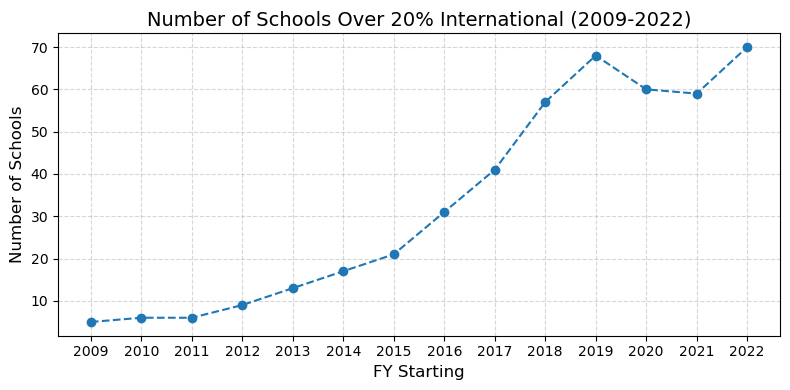

In [290]:
# Initialize an empty list to store the number of schools for each year
years = list(range(2009, 2023))
schools_passing = []

# Loop through each year and calculate the number of schools that passed 20% international enrolment
for year in years:
    passed_count = combined_df[
        (combined_df['FY Start'] == year) &
        (combined_df['% International'] > 20) &
        (combined_df['Francophone'] == 0) &
        (~combined_df['Institution Name'].str.contains("Total|Average"))
    ].shape[0]
    schools_passing.append(passed_count)

# Plotting the results
plt.figure(figsize=(8, 4))
plt.plot(years, schools_passing, marker='o', linestyle='--')
plt.title('Number of Schools Over 20% International (2009-2022)', fontsize=14)
plt.xlabel('FY Starting', fontsize=12)
plt.ylabel('Number of Schools', fontsize=12)
plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.xticks(years)  # Ensure all years are shown on the x-axis
plt.tight_layout()
plt.show()

In [291]:
# The pre-Covid peak was 2019. How many schools?
combined_df[
    (combined_df['FY Start'] == 2019) &
    (combined_df['% International'] > 20) &
    (combined_df['Francophone'] == 0) &
    (~combined_df['Institution Name'].str.contains("Total|Average"))
].shape

(68, 7)

We can see 2021 is a 2 year low from **the peak in 2019, where 68 schools** had more than 20% international students.

When we looked at raw international student numbers across Canada earlier, it increased by ~30,000 from 2020 to 2021. 

If we know two things:

- The number of schools with 20% international enrolment went down slightly
- Domestic enrolment has flatlined

Then where did the extra 30,000 international students go? Are they enrolling at schools already above this threshold?

In [292]:
# confirm the assumption above - total domestic students went down from 2019-2021
canada_dom[
    canada_dom['FY Start'].isin([2019, 2020, 2021])
][['FY Start', 'Canadian Status', 'Enrolment']]

,FY Start,Canadian Status,Enrolment
10,2019,Canadian students,1349823
11,2020,Canadian students,1357824
12,2021,Canadian students,1347282


In [293]:
# the same code above for international enrolment
canada_intl[
    canada_intl['FY Start'].isin([2019, 2020, 2021])
][['FY Start', 'Canadian Status', 'Enrolment']]

,FY Start,Canadian Status,Enrolment
10,2019,International students,340227
11,2020,International students,329334
12,2021,International students,360162


That is confirming that around 10,000 domestic students were lost from AY 20/21 to 21/22, whilst nearly 31,000 international students were gained, whilst less institutions were 20% international.

So where did they go?

In [294]:
# Filter to 2020/2021, exclude francophone, then group & sum
df_20_to_21 = (
    combined_df[
        combined_df['FY Start'].isin([2020, 2021]) 
        & (combined_df['Francophone'] == 0)
    ]
    .groupby(['Province/Territory', 'FY Start'])[['International Enrolment', 'Domestic Enrolment']]
    .sum()
)

# Unstack FY Start so 2020 and 2021 become separate columns
df_20_to_21_unstacked = df_20_to_21.unstack(level='FY Start')

# Compute the YoY change: (2021 - 2020)
df_20_to_21_unstacked[('Domestic Change YoY', '')] = (
    df_20_to_21_unstacked[('Domestic Enrolment', 2021)]
    - df_20_to_21_unstacked[('Domestic Enrolment', 2020)]
)

df_20_to_21_unstacked[('International Change YoY', '')] = (
    df_20_to_21_unstacked[('International Enrolment', 2021)]
    - df_20_to_21_unstacked[('International Enrolment', 2020)]
)

# Tidy up columns by flattening the MultiIndex and resetting index
df_20_to_21_unstacked.columns = [
    f"{col[0]}_{col[1]}" if col[1] else col[0]  # e.g. ('Domestic Enrolment', 2020) --> 'Domestic Enrolment_2020'
    for col in df_20_to_21_unstacked.columns
]
df_20_to_21_unstacked = df_20_to_21_unstacked.reset_index()

df_20_to_21_unstacked.sort_values(by='International Change YoY', ascending=False)

,Province/Territory,International Enrolment_2020,International Enrolment_2021,Domestic Enrolment_2020,Domestic Enrolment_2021,Domestic Change YoY,International Change YoY
6,Ontario,342756,388290,1124508,1110798,-13710,45534
0,Alberta,45282,48786,306222,309732,3510,3504
2,Manitoba,18960,21378,78870,78762,-108,2418
3,New Brunswick,4608,5946,27162,27300,138,1338
9,Saskatchewan,11556,12048,71448,71400,-48,492
7,Prince Edward Island,3846,3810,9762,10044,282,-36
8,Quebec,37572,37506,122172,121254,-918,-66
4,Newfoundland and Labrador,7398,6630,32142,32868,726,-768
5,Nova Scotia,20436,19560,70410,75648,5238,-876
1,British Columbia,97842,96504,252888,250854,-2034,-1338


In the above, the provinces are sorted by the largest change in international student enrolment. It is clear that Ontario was above and beyond the largest contributor to international student enrolment even when the other largest provinces - Quebec, BC and Alberta - had a combined ~2000 extra students between them enrolled in 2021.

- Side note: Note that Year-on-Year from 20-21 to 21-22, Ontario also had the largest decline in domestic enrolment by some distance, and the 'big provinces' all had slightly different outcomes. I'm careful to note [Laurentian University's financial insolvency in February 2021](https://www.cbc.ca/news/canada/sudbury/laurentian-university-creditor-protection-1.5896522) but this did not stop Laurentian student recruitment, and Domestic enrolment only decreased 1100 students YoY, very similar declines took place at many ON institutions YoY from 20-21 to 21-22.

The only way this larger international enrolment in raw umbers but not institutions (those over 20% international enrolment) makes sense is that the schools already above 20% international were the ones recruiting even more enrolment during the pandemic.

Let's check the 2021 schools over 20% and where they were in 2019 - were they below the threshold still accelerating, or were they already there but stalled by covid?

In [295]:
# Step 1: Identify the schools that were above the 20% Int'l in 2021
schools_above_20_in_2021 = combined_df[(combined_df['FY Start'] == 2021) & (combined_df['% International'] > 20) & (combined_df['Francophone'] == 0) & (~combined_df['Institution Name'].str.contains("Total|Average"))
]['Institution Name'].unique()

# Step 2: Retrieve the 2021 Percentages for these schools
percentages_2021 = combined_df[(combined_df['FY Start'] == 2021) & (combined_df['Institution Name'].isin(schools_above_20_in_2021))
][['Institution Name', '% International']].rename(columns={'% International': '% Intl 2021'})

# Step 3: Retrieve the 2019 percentages for the same schools
percentages_2019 = combined_df[(combined_df['FY Start'] == 2019) & (combined_df['Institution Name'].isin(schools_above_20_in_2021))
][['Institution Name', '% International']].rename(columns={'% International': '% Intl 2019'})

# Step 4: Merge the 2019 and 2021 percentages to calculate the change
percent_change = pd.merge(percentages_2019, percentages_2021, on='Institution Name', how='inner')
percent_change['Change in %'] = percent_change['% Intl 2021'] - percent_change['% Intl 2019']

# Display the result
percent_change.sort_values(by='Change in %', ascending=False)

,Institution Name,% Intl 2019,% Intl 2021,Change in %
5,Canadore College,38.57,74.77,36.20
27,Loyalist College,36.84,69.23,32.39
42,Sault College,26.85,58.26,31.41
47,St. Clair College,20.40,47.42,27.02
24,Kwantlen Polytechnic U,32.26,44.73,12.47
25,Lambton College,72.53,84.70,12.17
0,Algoma U,56.61,68.06,11.45
57,Vancouver CC,40.87,50.52,9.65
9,Coast Mountain College,47.23,56.22,8.99
44,Seneca College,37.10,45.28,8.18


In [296]:
percent_change.shape

(59, 4)

In [297]:
print(f"Of the 59 schools over 20% in 2021, {percent_change[percent_change['% Intl 2019'] > 20].shape[0]} were already over in 2019")
print(f"Of the 59 schools over 20% in 2021, {percent_change[percent_change['% Intl 2019'] > 33].shape[0]} were already over 33% in 2019")
print(f"Of the 59 schools over 20% in 2021, {percent_change[percent_change['% Intl 2019'] > 50].shape[0]} were already over 50% in 2019")

Of the 59 schools over 20% in 2021, 56 were already over in 2019
Of the 59 schools over 20% in 2021, 26 were already over 33% in 2019
Of the 59 schools over 20% in 2021, 8 were already over 50% in 2019


**The picture emerging is that the schools that had leaned into international the most by 2021 had already done so by 2019.** COVID-19 either substantially reversed that large increase between 2011 and 2019, or they punched straight through it, presumably by online offerings in the interim.

Below we look at the schools that held steady in composition during the COVID pandemic:

In [298]:
# Schools that did not swing by more than 5 percent
steady_schools = percent_change[
    (percent_change['Change in %'] >= -10) &
    (percent_change['Change in %'] <= 10)
]
steady_schools.shape

(48, 4)

In [299]:
# Schools that increased, or decreased by more than 5 percent between 2019 and 2021
swing_schools = percent_change[
    (percent_change['Change in %'] < -10) |
    (percent_change['Change in %'] > 10)
]

print(swing_schools.shape)
swing_schools.sort_values(by='Change in %', ascending=False)

(11, 4)


,Institution Name,% Intl 2019,% Intl 2021,Change in %
5,Canadore College,38.57,74.77,36.20
27,Loyalist College,36.84,69.23,32.39
42,Sault College,26.85,58.26,31.41
47,St. Clair College,20.40,47.42,27.02
24,Kwantlen Polytechnic U,32.26,44.73,12.47
25,Lambton College,72.53,84.70,12.17
0,Algoma U,56.61,68.06,11.45
40,Royal Roads U,45.31,33.82,-11.49
6,Cape Breton U,61.99,49.05,-12.94
34,North Island College,35.29,21.64,-13.65


In the schools that increased international student % by more than 10pp during the pandemic, up **or** down, more schools shifted up than shifted down, despite the restrictions during this time. 

It's noticeable that the up swingers are generally in Ontario whilst those declining are in BC, possibly reflecting different provincial public health policy and the postsecondary institutions individual operational decisions.

The overall effect of COVID on international student enrolment for PSIs, it seems, was most pronounced for the schools that changed the most either side of these COVID years. Some of the most explosive growers bouncing back in 2021 were the most aggressive growers before 2020, meanwhile 4 of the 5 hardest declines from 2019-2021 were also over half international in 2019.

### Some small schools **exploded** into international growth

I used a 20% international student bar as a marker of schools that serve a significant international student population, relative to their size. 

Six schools were there in 2011, 58 were there in 2021 as discussed above, but a lot of schools went well beyond the one in five 'lower boundary'. 

Below we can see 28 of those went above 33% International

In [300]:
# Half of the schools over 20% international in 2021 were already over 33%
combined_df[
    (combined_df['FY Start'] == 2021) &
    (combined_df['% International'] > 33) &
    (combined_df['Francophone'] == 0) &
    (~combined_df['Institution Name'].str.contains("Total|Average"))
].shape

(28, 7)

Is there a pattern to where these schools are? Let's look at 2022, the most recent data. 

In [415]:
from plotly.subplots import make_subplots

# Create a subplot figure with two columns for the pie charts
fig = make_subplots(
    rows=1, cols=2, 
    specs=[[{'type': 'domain'}, {'type': 'domain'}]],  # Specify the type as 'domain' for pie charts
    subplot_titles=(
        'Location of Anglophone Canadian PSIs over 20% international, 2022-23',
        'Location of Anglophone Canadian PSIs over 33% international, 2022-23'
    )
)

# Filter the data for the first pie chart
data_25 = combined_df[
    (combined_df['FY Start'] == 2022) &
    (combined_df['% International'] > 20) &
    (combined_df['Francophone'] == 0) &
    (~combined_df['Institution Name'].str.contains("Total|Average"))
]

# Filter the data for the second pie chart
data_50 = combined_df[
    (combined_df['FY Start'] == 2022) &
    (combined_df['% International'] > 33) &
    (combined_df['Francophone'] == 0) &
    (~combined_df['Institution Name'].str.contains("Total|Average"))
]

# Add the first pie chart to the subplot
fig.add_trace(
    go.Pie(
        labels=data_25['Province/Territory'],
        title='>20% Int\'l',
        textinfo='percent+label',
        hole=0.3  # Optional: make it a donut chart
    ),
    row=1, col=1
)

# Add the second pie chart to the subplot
fig.add_trace(
    go.Pie(
        labels=data_50['Province/Territory'],
        title='>33% Int\'l',
        textinfo='percent+label',
        hole=0.3  # Optional: make it a donut chart
    ),
    row=1, col=2
)

# Update the layout of the figure
fig.update_layout(
    template='plotly_dark'
)

# Show the figure
fig.show()

In [302]:
combined_df[(combined_df['FY Start'] == 2022) & (combined_df['% International'] > 33) & (~combined_df['Institution Name'].str.contains("Total|Average")) & (combined_df['Francophone'] == 0)]

,Institution Name,Province/Territory,FY Start,Domestic Enrolment,International Enrolment,Francophone,% International
41,Algoma U,Ontario,2022,741,2562,0,77.57
83,Assiniboine CC,Manitoba,2022,1176,684,0,36.77
219,Cambrian College,Ontario,2022,2601,4803,0,64.87
275,Canadore College,Ontario,2022,1782,4956,0,73.55
289,Cape Breton U,Nova Scotia,2022,1428,3330,0,69.99
303,Capilano U,British Columbia,2022,3213,2082,0,39.32
345,Centennial College,Ontario,2022,8298,11559,0,58.21
373,Coast Mountain College,British Columbia,2022,246,387,0,61.14
387,College of New Caledonia,British Columbia,2022,1095,825,0,42.97
784,Conestoga College,Ontario,2022,7788,14292,0,64.73


How extensive has the transition been in some schools?

Below are the schools **over 50% international**.

In [303]:
# schools with >50% international in 2022
combined_df[
    (combined_df['FY Start'] == 2022) &
    (combined_df['% International'] > 50) &
    (combined_df['Francophone'] == 0) &
    (~combined_df['Institution Name'].str.contains("Total|Average"))
].sort_values(by='% International', ascending=False)

,Institution Name,Province/Territory,FY Start,Domestic Enrolment,International Enrolment,Francophone,% International
1776,Lambton College,Ontario,2022,1794,11736,0,86.74
2127,Northern College,Ontario,2022,1119,4164,0,78.82
41,Algoma U,Ontario,2022,741,2562,0,77.57
1832,Loyalist College,Ontario,2022,1602,5049,0,75.91
275,Canadore College,Ontario,2022,1782,4956,0,73.55
289,Cape Breton U,Nova Scotia,2022,1428,3330,0,69.99
2423,Sault College,Ontario,2022,1152,2463,0,68.13
219,Cambrian College,Ontario,2022,2601,4803,0,64.87
784,Conestoga College,Ontario,2022,7788,14292,0,64.73
2041,Niagara College Canada,Ontario,2022,4803,8523,0,63.96


These schools over 50% now have the majority of their operations for international students. They are mostly small colleges with domestic enrolment in the 1,000 - 3,000 ballpark that have enrolled that number or multiple times that number in international students in this ten year period. They **rapidly transformed** into predominantly international service providers. Of the original six in 2011 over 20% international students, Centennial and Cape Breton are here, and CBU is typical of this agressive growth where they now service an international base over twice their domestic contingent.

For the most part, these institutions started 2011 as small groups that had next to no international student representation. In the period from 2011-2022 most of them declined domestically as they grew internationally.

In [304]:
# look at the schools with over 50% in 2022 but in 2011
over_half_schools = combined_df[
    (combined_df['FY Start'] == 2022) &
    (combined_df['% International'] > 50) &
    (combined_df['Francophone'] == 0) &
    (~combined_df['Institution Name'].str.contains("Total|Average"))
]['Institution Name'].unique()

# Filter the data for these schools in 2011
combined_df[
    (combined_df['FY Start'] == 2011) &
    (combined_df['Institution Name'].isin(over_half_schools))
]

,Institution Name,Province/Territory,FY Start,Domestic Enrolment,International Enrolment,Francophone,% International
30,Algoma U,Ontario,2011,819,72,0,8.08
208,Cambrian College,Ontario,2011,4194,78,0,1.83
264,Canadore College,Ontario,2011,1287,129,0,9.11
278,Cape Breton U,Nova Scotia,2011,1899,597,0,23.92
334,Centennial College,Ontario,2011,9651,3375,0,25.91
362,Coast Mountain College,British Columbia,2011,642,0,0,0.00
773,Conestoga College,Ontario,2011,8886,633,0,6.65
1550,Georgian College,Ontario,2011,7362,234,0,3.08
1695,Kwantlen Polytechnic U,British Columbia,2011,8220,867,0,9.54
1765,Lambton College,Ontario,2011,6858,186,0,2.64


#### Different provinces had different numbers of **'transformers'**

These are **small institutions in 2011 which massively increased in international student enrolment.** They are distinct from:
- Schools which already began the period with a significant international population like Centennial Centennial College, or 
- Those that added a lot of international students alongside a large domestic base like Seneca, Centennial, George Brown or York University. 

With domestic enrolment flatlined almost everywhere in Canada, it's not unreasonable that these previously small regional schools that have rapidly grown to multiples of their original size almost entirely off of international students. These schools are threatened the most with any restrictions to the flow of international students, as they cannot even rely on a sizeable domestic student populace to serve and receive funding.

**Ontario has the most explosive transformers** - Lambton College, Northern College, Canadore College, Algoma University, Cambrian College, Loyalist College and Conestoga College all began the period with at most 10% international student enrolment. With the exception of Conestoga College at 8000 domestic students, these were small sub-5000 student schools with 2011 international student numbers often in the hundreds. 

All of these schools entered 2021-22 with international students making at least the majorty of their student body, often multiple times the domestic count, like Lambton College which was around 85% international in 2021, and Algoma, Loyalist, Canadore and Northern College all above 67%.

- Lambton College has strange data in 11-12 and 12-13 where Domestic enrolment then drops off a cliff for 13-14. I will check the MCU (provincial body) data for clarity, as it's more granular, but I suspect their domestic enrolment is around the 2-3k mark in 2011-2013.
    
- Cambrian College also had some early data in the MCU repository clouded by the 'Other' Category.

**BC's transformers were not nearly as explosive as those in Ontario**. No BC institution passed 60% international by 2021 which was a lower boundary for the explosive growers in Ontario. In BC, Coast Mountain College (CMC), Northern Lights College, Langara College, College of New Caledonia (CNC) Kwantlen Polytechnic University (KPU), Vancouver Community College (VCC) and Selkirk College grew the highest share of international students in their makeup, all starting 2011 with < 10% international and all touched or exceeded 40% at some point in the most recent 3-4 years of the reference period. Some have peaked and dropped off like CNC, but it may be COVID related in 2020-2021.

- If we are trying to identify transformers as *small* schools that effectively changed their principal market from domestic to international, a *small school* is going to be smaller in BC than in ON by virtue of ON being nearly 3x the population. 
    - Langara began 2011 with 5,700 domestic students, KPU with 8,200 and this puts them in the category of  where the others were around 2,000 or below. Langara and KPU have both effectively become equal domestic and international students, closing a gap of 5.5-8k students.

    - Coast Mountain College and Northern Lights College are both sub-1000 domestic enrolment in 2011 so their ratios are going to be more sensitive to raw numbers.

Transformers were often but not always colleges - Cape Breton University, Algoma University and Kwantlen Polytechnic University all rapidly grew in international students with a small domestic base.

# Conclusions of this notebook

We can draw a few conclusions from this work book:

- Rapid growth and expansion of international student enrolment has occurred in the last 15 years against a flatlined domestic student populace across all of Canada.

- Pre- and Post-Covid, international student enrolment was growing exponentially when totalled at the nationwide level. However, this growth is concentrated overwhelmingly in Ontario, specifically in its colleges. The outcome is many ON colleges now serving more international students than domestic students (over 50% international student share of enrolment).
    - The data in the Covid-impacted years of 20-21 and 21-22 sets Ontario's institutions apart. Domestic enrolment fell 13,700 Year-on-Year, whilst international enrolment increased by 45,000. They are the only large province that simultaneously lost domestic enrolmen (six times the next nearest provincial drop in BC) whilst growing international enrolment (over ten times Alberta's growth).

- Many of these Ontario colleges were small institutions in 2011. Several were serving less than 2,500 domestic students and barely a few hundred international students. The transformation from small regional institution to international educational brand presumably has a lot of operational implications, depending on pre existing size, geographic location, program offering, etc...

# What have I missed?

(To be explored in more detail) 

It is possible that these data are conservative estimates of international student enrolment in all PSIs, private and public.  I have not yet found comprehensive 2023/24 data but according to this [January 2024 article](https://www.theglobeandmail.com/politics/article-number-of-international-students-now-exceeds-one-million-official/#:~:text=An%20IRCC%20document%20from%20August,over%20one%20million%20in%202024.), there were then more than 1 million approved study permit holders in Canada. 

This is 600,000 more than the 430,000 I found in 22/23 in this workbook. This might include K-12 students, but it is unclear, and frustratingly the Globe and Mail don't specify or provide the 'official sources' data quoted in the above article to examine.

The data for Ontario Colleges, with PCPPs that drove a lot of international student growth, are likely worth exploring specifically. 
- Ontario MCU's [Policy Directive on PCPPs is here](https://files.ontario.ca/mcu-public-college-private-partnerships-march-2023-en-2023-03-14.pdf) which outlined 7,500 students max through these schemes, which can be assessed against the enrolment they are required to report by campus, which is available from MCU's data centre
- [Analysis of PCPPs by HEQC in Ontario](https://heqco.ca/pub/public-college-private-partnerships-lessons-learned-for-ontarios-postsecondary-education-system/) - paper explores the enrolment in the PCPP programs against labour market needs via job postings - I will look at the CIP list by IRCC

### [List of PCPPs in Ontario](https://pcici.ca/public-private-partnership-colleges-ontario/)
- Verify these in conjunction with Ontario enrolment from MCU, which lists enrolment by Campus

### Where might the rest of the students be?
- **This must include K-12 students - confirm**
- StatCan draws its data from [PSIS](https://www23.statcan.gc.ca/imdb/p2SV.pl?Function=getSurvey&Id=1530650) which only collects information from public and private (not for profit) institutions funded by a Ministry of Education. Institutions like University Canada West in Vancouver which has [over 14,000 students](https://www.ucanwest.ca/about/overview-facts) do not report information to PSIS.
- There are a number of public-private college partnerships in Ontario where a private (for profit) college is licenced to deliver a public college's curriculum, and other private colleges where transfer mechanisms to public colleges exist. However, it was [only in November 2024](https://www.canada.ca/en/immigration-refugees-citizenship/news/2024/11/new-international-student-program-regulations-take-effect.html) that any mandatory reporting of international student attendance, and study permit compliance began. It's not clear if the enrolment at those would count under the public college (presumably then I have captured it from StatCan) or with the private college.
- This [CBC article](https://www.cbc.ca/news/canada/toronto/international-student-study-permits-data-1.7125827#Full%20data) show approved study permits in 2023 at around 430,000 which tracks with my numbers for 2022-23.